# Simulations of a Dual-system model of actions and habits

**Authors**:

Omar D. Perez

Anthony Dickinson

This is the code (in Python 2) for the paper "A theory of actions and habits: the interaction of rate-correlation and contiguity systems in free-operant behavior" by Perez and Dickinson (2020), published in Psychological Review. To run these simulations you'll need to load the libraries numpy, pandas, seaborn and matplotlib. 


### Load Libraries

In [1]:
from __future__ import division # so that division by integer gives float
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
# import matplotlib.patches as mpatches
import seaborn as sns, os
%pylab inline
figsize(40, 40);
import numpy as np, csv, pandas as pd
from scipy.stats.stats import pearsonr # Pearson's correlation
%matplotlib inline
import datetime
from collections import deque
from pandas import DataFrame

Populating the interactive namespace from numpy and matplotlib


### First we define some general parameter and classes.

In [2]:
class Schedule():
    def __init__(self, name, parameter, m, RIplus_ratio=30):
        self.name = name # RR, RI etc
        self.parameter = parameter # ratio requirement for the RR, interval for the RI, etc
        self.m = m # memory size for the RPI
        self.RIplus_ratio = RIplus_ratio # this is the resp requirement for the RI
    
    def giveRnf(self):
        global rnfFlag, pRPI, IRT, resp_time, nResp, nReinf, rnf_time,\
        t_since_last_rnf, n_resp_since_last_rnf,\
        rnfProb, rnfs_per_session, rnfProb_master_rat, session, writer_object2, k
        
        resp_time.append(t) # append time of responding
        #nResp = len(resp_time) # count the number of responses so far         
        
        n_resp_since_last_rnf += 1 # count responses since last reinforcement
        #t_since_last_rnf = t - rnf_time[-1] if len(rnf_time) > 1 else t # this is i in the RIplus formula
        
        if sum(resp) > 2:
            IRT.append(resp_time[-1] - resp_time[-2]) # calculate current IRT
        
        if self.name == 'RR':
            reinf[t] = np.random.binomial(1, 1/schedule.parameter) # give rnf with probability 1/schedule.parameter
            n_resp_since_last_rnf = 0 if reinf[t] else n_resp_since_last_rnf # reset if rnf given
        elif self.name == 'RI' or 'RIplus' or 'FI':
            if rnfFlag:
                reinf[t] = 1                
                n_resp_since_last_rnf = 0 # reset if rnf given
                rnf_time.append(t)
                rnfFlag = False
                if self.name == 'FI':
                    k+=1
        elif self.name == 'RPI':
            if sum(resp) > self.m:                
                t_num = sum(IRT[-self.m: -1]) # t in t/(T*m)                
                pRPI = t_num/(self.parameter*self.m) # probability of reinf in the RPI
                reinf[t] = np.random.binomial(1, pRPI)  # toss coin; if comes up head, reinforce, otherwise zero                
                n_resp_since_last_rnf = 0 if reinf[t] else n_resp_since_last_rnf # reset if rnf given
            else: # if nResp < m, don't reinforce
                reinf[t] = 0   
        elif self.name == "extinction":
            reinf[t] = 0
        
        if reinf[t]: # update number of reinforcers if response was rewarded
            nReinf += 1                 
        
        if nReinf == rnfs_per_session: # if nReinf reaches the preset nReinf for each session        
            save_session_data()
            #print("nResp: %i")%nResp
            rnfProb[rat, session] = nReinf/nResp # calculate rnfProb for this session
            #print("RnfProb: %g")%rnfProb[rat, session]
            session += 1
            #print("Session %i starts")%session     
            nResp, nReinf = 0, 0 # reset nResp and nReinf for next session
              
class Exp():
    def __init__(self, nLevers, nCycles, nRats, nSessions):
        self.nLevers = nLevers # number of levers active
        self.nCycles = nCycles # number of cycles
        self.nRats = nRats # number of rats
        self.nSessions = nSessions # number of sessions of the experiment
         
class Cycle():
    def __init__(self, prob, winNumber, winLength, D, C):
        self.prob = prob # prob of responding for each cycle
        self.winNumber = winNumber # winNumber for each cycle (-1 for all cycles except first one)
        self.winLength = winLength # length of each window in a cycle
        self.D = D # this is the motivational factor for habits (Hull's "Drive")
        self.C = C # weight for EWMA in correlations
        


### Calculate rate-correlations for g-d system

The next two chunks of code are 1) the correlations experienced by each rat and 2) the reinforcement learning system for the habitual component; both of these are part of the rat's internal processes, not the environment. The environment is described by the chunk generating response and reinforcement according to the schedule in effect during the simulated experiment.

The logic of the simulations is the following:
1) Create a first memory cycle of the same length as the memory size of the subject
2) Calculate h of next cycle
3) Calculate g of next cycle
4) Calculate p of next cycle
5) if cycle is not 1, size of cycle is 1 window
6) delete first window of previous cycle and attach new window 
7) Repeat steps 1-4

In [3]:
# this function slices the array of responses and reinforcers to calculate the correlations
chunk_this_vector = lambda array, size: [array[i : i+size] for i in range(0, len(array), size)]

def calculate_corr():
    # these vectors save the number of responses and reinforcers per window
    global respPerWinLastCycle, reinfPerWinLastCycle
    
    if cycle_number == 0: # for the 1st cycle, generate a cycle with all windows
        respPerWin, reinfPerWin = np.zeros(cycle.winNumber), np.zeros(cycle.winNumber)
        
        # chunk the vectors for resp and reinf according to winLength
        respChunked = chunk_this_vector(resp, cycle.winLength) # this chunks the resp vector
        reinfChunked = chunk_this_vector(reinf, cycle.winLength) # same for the reinf vector
        
        for win in xrange(cycle.winNumber):
            respPerWin[win] = sum(respChunked[win]) # sum responses in each win
            reinfPerWin[win] = sum(reinfChunked[win]) # sum reinforcers in each win
    else:
        respPerWin = np.append(respPerWinLastCycle, sum(resp)) # append wins 2,...,n with current window = whole cycle
        reinfPerWin = np.append(reinfPerWinLastCycle, sum(reinf))

    respPerWinLastCycle, reinfPerWinLastCycle = respPerWin[1:len(respPerWin)], reinfPerWin[1:len(reinfPerWin)]# vectors with all but first window
    
    # calculate experienced rate correlation for this cycle
    g = pearsonr(respPerWin, reinfPerWin)[0]
    return g

### Calculate the probabilites for the habit system

In [4]:
#a = 0.005 # this is beta +
#b = 0.00005 # this is beta -

def calculate_h(a, b):
    ''' This is the Reinforcement Learning function for the habit system. 
    In each time point, it updates the habit strength. 
    In each cycle, it starts with the accumulated strength up to the previous cycle,(ph[cycle_number-1]) '''
    
    h = np.zeros(int(T[cycle_number])) # t[cycle_number] = length of cycle
    h[0] = ph[cycle_number-1] if cycle_number != 0 else 0 # here we take the last accumulated h 
    
    #i = np.zeros(int(T[cycle_number])) # t[cycle_number] = length of cycle
    #i[0] = pi[cycle_number-1] if cycle_number != 0 else 0 # here we take the last accumulated h 
    
    for t in xrange(int(T[cycle_number])-1): # for all  t in current cycle, until previous to last t
        if resp[t] and reinf[t]:
            h[t+1] = h[t] + a*(1 - (h[t] + pg[cycle_number])) # - b*h[t]
            #i[t+1] = i[t]
        elif resp[t] and not reinf[t]:
            h[t+1] = h[t] - b*(h[t] + pg[cycle_number]) # b*h[t]i[t+1] = i[t] + b*((i[t]+pg[cycle_number]) - i[t])  #+ pg[cycle_number]) #(ph[cycle_number] + pg[cycle_number])
            #h[t+1] = h[t]
        else: 
            h[t+1] = h[t]
            #i[t+1] = i[t]
    return h[-1]
    

## Handy functions

In [5]:
def init_values_this_rat():
    session = 0 # initialise counter for session
    
    T = np.zeros(exp.nCycles) # length of each cycle = WinNumber*WinLength   
    ph, pi, pg, p = np.zeros(exp.nCycles), np.zeros(exp.nCycles), np.zeros(exp.nCycles), np.zeros(exp.nCycles) # probs for each system in each memory cycle
    nRespCycle, nReinfCycle = np.zeros(exp.nCycles), np.zeros(exp.nCycles) # nResp and nReinf in each memory cycle
    nResp, nReinf = 0, 0
    
    #if schedule.name=="RR":
    #    rnfProb_master_rat = rnfProb    
    
    rnfs_per_session = 30 #range(0, 300 + nReinf_per_session, nReinf_per_session) # 30 reinf/session until 300 rnf = 10 sessions
    #rnfs_per_session.pop(0) # delete the first zero
#     rnfs_per_experiment = rnfs_per_session*exp.nSessions #(nReinf_per_session)*(rnfs_per_session[-1]/nReinf_per_session)
        
    # set the first cycle
    cycle = Cycle(prob=0.05, winNumber=20, winLength=20, D=1, C=.1) # C is weight for correlations; D is drive for habit system
    
    respPerMin = cycle.prob*60 # this is the total number of responses per min in each cycle
    #print('resp per min: %g') %respPerMin
    
    return session, T, ph, pi, pg, p, nRespCycle, nReinfCycle, nResp, nReinf, rnfs_per_session, cycle, respPerMin

def init_values_this_cycle():
   # length of each cycle. 1st cycle has length = winlength*winNumber; 
    #the following ones are just 1 window long
    T[cycle_number] = cycle.winLength*cycle.winNumber if cycle != 0 else \
    cycle.winLength 

    if cycle_number == 0: # for 1st cycle, long cycle, then just one window long
        resp, reinf, engaged_vec = np.zeros(cycle.winLength*cycle.winNumber), np.zeros(cycle.winLength*cycle.winNumber), np.zeros(cycle.winLength*cycle.winNumber)            
    else:
        resp, reinf, engaged_vec = np.zeros(int(T[cycle_number])), np.zeros(int(T[cycle_number])), np.zeros(int(T[cycle_number])) 
    IRT, resp_time, rnf_time, n_resp_since_last_rnf = [], [], [0], 0
    
    return T, resp, reinf, IRT, resp_time, rnf_time, n_resp_since_last_rnf, engaged_vec


In [6]:
# sigmoid function for response probability
def sigmoid(x, a=1, temp=10, x0=0.6):
     return 1 / (1 + a*np.exp(-temp*(x-x0)))

In [7]:
def create_csv():
    ''' Create csv files to save data '''
    
    # This file saves ps for each CYCLE
    file_name = 'sims/%s_%s_' %(schedule.name, schedule.parameter)#, model)
    csv_file = open(file_name + str(datetime.datetime.now().strftime("%d-%m-%Y_%H-%M")) + '.csv', 'wb')
    writer_object = csv.writer(csv_file, delimiter=",") 
    writer_object.writerow(['cycle', 'prob_type', 'prob_value', 'rat', 'schedule', 'parameter'])

    # Save ps for each SESSION = 30 reinf, for ex.
    file_name2 = 'sims/%s_%s' %(schedule.name, schedule.parameter)#, model)
    #csv_file2 = open(file_name2 + str(datetime.datetime.now().strftime("%d-%m-%Y_%H-%M")) + '.csv', 'wb')
    csv_file2 = open(file_name2 + '.csv', 'wb')
    writer_object2 = csv.writer(csv_file2, delimiter=",") 
    writer_object2.writerow(['session', 'prob_type', 'prob_value', 'rat', 'schedule', 'parameter'])
    
    return csv_file, writer_object, csv_file2, writer_object2

def save_cycle_data():
    ''' Save data for this cycle in csv file'''
    writer_object.writerow([cycle_number, 'ph', ph[cycle_number],\
                            int(rat), schedule.name, schedule.parameter])
#     writer_object.writerow([cycle_number, 'pi', pi[cycle_number],\
#                             int(rat), schedule.name, schedule.parameter])
    writer_object.writerow([cycle_number, 'pg', pg[cycle_number],\
                            int(rat), schedule.name, schedule.parameter])
    writer_object.writerow([cycle_number, 'p', p[cycle_number],\
                            int(rat), schedule.name, schedule.parameter])

def save_session_data():
    #print("nReinf: %i")%nReinf
    #print("Session ended!")
    #print("p= %g")%p[cycle_number-1]
    writer_object2.writerow([session+1, 'h', ph[cycle_number-1],\
                             int(rat), schedule.name, schedule.parameter])
#     writer_object2.writerow([session+1, 'i', pi[cycle_number-1],\
#                              int(rat), schedule.name, schedule.parameter])
    writer_object2.writerow([session+1, 'g', pg[cycle_number-1],\
                             int(rat), schedule.name, schedule.parameter])
    writer_object2.writerow([session+1, 'p', p[cycle_number-1],\
                             int(rat), schedule.name, schedule.parameter])
    

In [8]:
sns.set(style='whitegrid', font_scale=.8)

def lineplot(filename):
    # create pandas dataframe from csv file created during simulations
    df = pd.read_csv('sims/'+filename+'.csv')
    #dataRR.tail()

    # lineplots for each system
#     sns.set(style='whitegrid', font_scale=.7)
    b = sns.pointplot(x='session', y='prob_value', data=df, dodge=True, hue='prob_type',
                      linestyles=['-', '-', '-'], markers=['x','^','o'], scale=1)
    axis = g.axes
    axis.set(ylim=(-.1, 1), ylabel='Probability of responding', xlabel='Session')
#     plt.legend(loc='right')

    # save plot
    plt.savefig(filename + '.png', dpi=800)
    return b

def bplot(filename):
    df = pd.read_csv('sims/'+filename+'.csv')
    print(df.head())
    b = sns.catplot(x="session", y="prob", hue="schedule", kind="bar",
                    dodge=True, data=df, ci=False)
    
    # save plot
    plt.savefig(filename + '.png', dpi=800)
    return b

# Simulations

In [9]:
def line_plot1(data):    
    g = sns.pointplot(x='session', y='prob_value', data=data, dodge=True, hue='prob_type', ci=None, scale=1)
    axis = g.axes
    axis.set(ylim=(-.1, 1.1), ylabel='Response strength, response probability', xlabel='Session')
    plt.legend(loc='right')


## Master interval 


### Here we initialise the variables and run the loop for cycle 1; the rest are only 1 window long. The chunks below run the yoked ratio schedule

In [115]:
# Instantiate exp and schedule classes
exp = Exp(nLevers=1, nCycles=2000, nRats=500, nSessions=10) # define exp object
schedule = Schedule(name='RI', parameter=15, m=5) # define schedule object

rnfFlag, cont_degradation, choice_training = False, False, False # flag to deliver reinforcer in RI; bool for cont_degradation training 

# create csv to save results 
csv_file, writer_object, csv_file2, writer_object2 = create_csv()

rnfProb = np.zeros([exp.nRats, exp.nSessions]) # this array saves the rnfProb for every session (after n reinforcers have been delivered)

# Now we take each rat and simulate cycles
for rat in xrange(int(exp.nRats)): # this is equivalent to repetition of the experiment
    #print("Rat: %i")%rat

    # initialise variables for this rat
    session, T, ph, pi, pg, p, nRespCycle, nReinfCycle, nResp, nReinf, \
    rnfs_per_session, cycle, respPerMin = init_values_this_rat()
    
#     session, T, ph, pi, pg, p, nRespCycle, nReinfCycle, nResp, nReinf, \
#     rnfs_per_session, cycle, respPerMin = init_values_this_rat()

    for cycle_number in xrange(exp.nCycles):        
        
        # finish this rat if number of sessions is the programmed one
        if session == exp.nSessions:
            break
        
        # initialise variables for this cycle
        T, resp, reinf, IRT, resp_time, rnf_time, \
        n_resp_since_last_rnf, engaged_vec = init_values_this_cycle()
        
        # This loops for every second
        for t in xrange(int(T[cycle_number])):
            
            # bait reinforcer according to schedule parameter
            if schedule.name in ['RI', 'RIplus']:
                if not rnfFlag: # this flags the reinf for RI
                    rnfFlag = np.random.binomial(1, 1/schedule.parameter) # if equal to 1, set the reinforcer.
            
            # Now generate the resp in this second
            resp[t] = np.random.binomial(1, cycle.prob)
            
            if resp[t]: # if a response, run the giveRnf method to see whether it is reinforced
                schedule.giveRnf()
                nResp += 1
            # for contingency degradation
            if cont_degradation:
                if not resp[t]: # if not responding, then deliver reinforcer with same probability
                    reinf[t] = np.random.binomial(1, 1/schedule.parameter)

        # calculate probs for each system, then sum 
        
        # this is g
        pg[cycle_number] = cycle.C*calculate_corr() + (1-cycle.C)*pg[cycle_number-1] if cycle_number > 0 else \
        calculate_corr() # prob g-d system
        
        if np.isnan(pg[cycle_number]): # if NA then fill with zero # this is the previous rule: pg[cycle_number-1]; replaced by mean pg
            pg[cycle_number] = 0 #pg[cycle_number-1] 
            
#         if p[cycle_number-1] : # at asymptote, g must be zero by definition
#             pg[cycle_number] = 0
    
        #elif pg[cycle_number]<0:
        #    pg[cycle_number] = 0 # pg[cycle_number-1] - .1*pg[cycle_number-1]
        
        # This is h
        ph[cycle_number], pi[cycle_number] = calculate_h(a=.02, b=.0000001) # if cycle_number !=0 else calculate_h() 
        
        if cycle_number == 0: # start with some pretraining value for pg and ph
            pg[cycle_number], ph[cycle_number], pi[cycle_number] = .8, .1, .1
        
        # p = h + g - hg
        p[cycle_number] = sigmoid(cycle.D*ph[cycle_number] + pg[cycle_number]) # - pi[cycle_number]) # - cycle.D*ph[cycle_number]*pg[cycle_number] 
                
#         p[cycle_number] = cycle.D*ph[cycle_number] + pg[cycle_number] - cycle.D*ph[cycle_number]*pg[cycle_number]      
        #print('ph = %g, pg = %g, p = %g')%(ph[cycle_number], pg[cycle_number], p[cycle_number])         
        
        # now assign these values for next cycle
        cycle.winNumber = 1 # only one window if not first cycle; above, the winNumber for first cycle was defined
        cycle.prob = p[cycle_number] if p[cycle_number] > 0 else 0 # set total prob of resp for each cycle 
        
        # write prob for each CYCLE and rat (not each second)
        save_cycle_data()

csv_file.close()
csv_file2.close()

#lineplot(schedule.name+'_'+str(schedule.parameter))

## Yoked ratio schedule

### Now the same code but modified to yoking; here we should use the rnfProb or number of reinforcers from previous code.

In [116]:
# Instantiate exp and schedule classes
exp = Exp(nLevers=1, nCycles=2000, nRats=500, nSessions=10) # define exp object
schedule = Schedule(name='RR', parameter=10, m=5)

rnfFlag, cont_degradation, choice_training = False, False, False # flag to deliver reinforcer in RI; bool for cont_degradation training 

# Create csv files to save data
csv_file, writer_object, csv_file2, writer_object2 = create_csv()

# take rnfProb from master rats
rnfProb_master_rat = rnfProb 

# Now we take each rat and simulate cycles
for rat in xrange(int(exp.nRats)): # this is equivalent to repetition of the experiment
    #print("Rat: %i")%rat

    # initialise variables for this rat
    session, T, ph, pi, pg, p, nRespCycle, nReinfCycle, nResp, nReinf, \
    rnfs_per_session, cycle, respPerMin = init_values_this_rat()

    
    for cycle_number in xrange(exp.nCycles):      
        
        if session == exp.nSessions:            
            #print("End of Experiment for rat %i")%rat
            break
        # this is the code to yoke the RR schedule
        #if schedule.name == 'RR':# and len(rnfProb_master_rat) > 0:
        if nReinf <= rnfs_per_session: # session changes inside the Exp class above
            schedule.parameter = 1/rnfProb_master_rat[rat, session]
            #print("schedule parameter = %g")%schedule.parameter    
            
        T[cycle_number] = cycle.winLength*cycle.winNumber if cycle != 0 else \
        cycle.winLength # 1st cycle has length = winlength*winNumber; the following ones are just 1 window long

        if cycle_number == 0: # for 1st cycle, long cycle, then just one window long
            resp, reinf = np.zeros(cycle.winLength*cycle.winNumber), np.zeros(cycle.winLength*cycle.winNumber)            
        else:
            resp, reinf = np.zeros(int(T[cycle_number])), np.zeros(int(T[cycle_number]))
        IRT, resp_time, rnf_time, n_resp_since_last_rnf = [], [], [0], 0
        
        # This loops for every second
        for t in xrange(int(T[cycle_number])):
            if schedule.name in ['RI', 'RIplus']:
                if not rnfFlag: # this flags the reinf for RI
                    rnfFlag = np.random.binomial(1, 1/schedule.parameter) # if equal to 1, set the reinforcer.
            
            # Now generate the resp in this second
            resp[t] = np.random.binomial(1, cycle.prob)
            if resp[t]: # if a response, run the giveRnf method to see whether it is reinforced
                schedule.giveRnf()
                nResp += 1
                
        #calculate probs for each system, then sum 
        pg[cycle_number] = cycle.C*calculate_corr() + (1-cycle.C)*pg[cycle_number-1] if cycle > 0 else calculate_corr() # prob g-d system
        
        if np.isnan(pg[cycle_number]): # if NA then fill with zero # this is the previous rule: pg[cycle_number-1]; replaced by mean pg
            pg[cycle_number] = 0#pg[cycle_number-1] 
            
#         if p[cycle_number-1] == 1: # at asymptote, g must be zero by definition
#             pg[cycle_number] = 0
            
        # This is h
        ph[cycle_number], pi[cycle_number] = calculate_h(a=.02, b=.0000001) # if cycle_number !=0 else calculate_h() 
        
        if cycle_number == 0: # start with some pretraining value for pg and ph
            pg[cycle_number], ph[cycle_number], pi[cycle_number] = .8, .1, .1
        
        # p = h + g - hg
        p[cycle_number] = sigmoid(cycle.D*ph[cycle_number] + pg[cycle_number]) # - pi[cycle_number]) # - cycle.D*ph[cycle_number]*pg[cycle_number]     
              
        cycle.winNumber = 1 # only one window if not first cycle; above, the winNumber for first cycle was defined
        cycle.prob = p[cycle_number] if p[cycle_number] > 0 else 0 # set total prob of resp for each cycle 
        
        # write prob for each CYCLE and rat (not each second)
        save_cycle_data()

csv_file.close()
csv_file2.close()

# plot the systems
#lineplot(schedule.name+'_'+str(start_parameter))

In [117]:
# Create merged dataFrame with master and yoked simulations
df_master = pd.read_csv('sims/RI_15.csv') 
df_yoked = pd.read_csv('sims/RR_10.csv')


In [118]:
# df_master.tail(40)

In [119]:
# sigmoid(.37162+.695697)

In [7]:
# import numpy as np

# x = np.linspace(-1,1,1000)

# # y = sigmoid(x )

# plt.plot(x, sigmoid(x,temp=10, x0=.6))
# plt.ylim(0,1)
# plt.xlim(0,1)

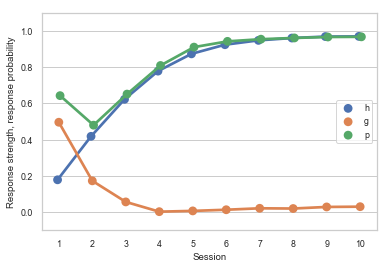

In [132]:
sns.set(style='whitegrid', font_scale=.8)
p1 = line_plot1(df_master)
plt.savefig('sims/RI_master.png', dpi=600)


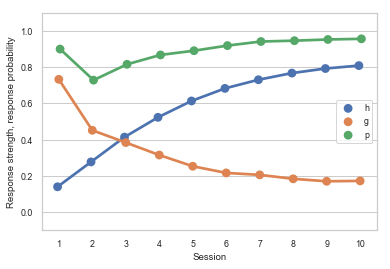

In [133]:
sns.set(style='whitegrid', font_scale=.8)
p2 = line_plot1(df_yoked)
plt.savefig('sims/RR_yoked.png', dpi=600)

## Barplots for responding under different extensions of training

In [135]:
df_master_early_late = df_master[df_master["session"].isin([2,5,10])] # create dataframe with only last session
df_master_early_late.head()

,session,prob_type,prob_value,rat,schedule,parameter
3,2,h,0.415891,0,RI,15
4,2,g,-0.028651,0,RI,15
5,2,p,0.106443,0,RI,15
12,5,h,0.888025,0,RI,15
13,5,g,0.047632,0,RI,15


In [136]:
df_yoked_early_late = df_yoked[df_yoked["session"].isin([2,5,10])] # create dataframe with only last session
df_yoked_early_late.head()

,session,prob_type,prob_value,rat,schedule,parameter
3,2,h,0.230149,0,RR,8.566667
4,2,g,0.546851,0,RR,8.566667
5,2,p,0.854458,0,RR,8.566667
12,5,h,0.547786,0,RR,9.600000
13,5,g,0.471763,0,RR,9.600000


In [137]:
df_early_late = df_master_early_late.append(df_yoked_early_late)
df_early_late = df_early_late[df_early_late.prob_type=='p']
df_early_late.head()

,session,prob_type,prob_value,rat,schedule,parameter
5,2,p,0.106443,0,RI,15.0
14,5,p,0.966319,0,RI,15.0
29,10,p,0.935934,0,RI,15.0
35,2,p,0.125683,1,RI,15.0
44,5,p,0.642491,1,RI,15.0


In [138]:
df_early_late.tail()

,session,prob_type,prob_value,rat,schedule,parameter
14954,5,p,0.529635,498,RR,9.700000
14969,10,p,0.990574,498,RR,15.033333
14975,2,p,0.704152,499,RR,7.700000
14984,5,p,0.559155,499,RR,16.633333
14999,10,p,0.999464,499,RR,14.400000


Plot responding early and late in training

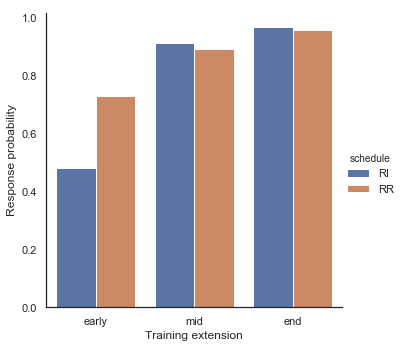

In [139]:
sns.set(style='white', font_scale=1)

g = sns.catplot(x="session", y="prob_value",
                hue="schedule", kind="bar", dodge=True,
                data=df_early_late, ci=False)

(g.set_axis_labels("Training extension", "Response probability")
 .set_xticklabels(["early", "mid", "end"]))

# axis.set(ylim=(-.1, 1), ylabel='Response strength', xlabel='Session')
# plt.legend(loc='right')
plt.savefig('sims/resp_rates_early_late.png', dpi=600)

Plot devaluation ratio for ratio and interval

In [140]:
df_early_late_dev_ratio = df_master_early_late.append(df_yoked_early_late)
df_early_late_dev_ratio.head()

,session,prob_type,prob_value,rat,schedule,parameter
3,2,h,0.415891,0,RI,15.0
4,2,g,-0.028651,0,RI,15.0
5,2,p,0.106443,0,RI,15.0
12,5,h,0.888025,0,RI,15.0
13,5,g,0.047632,0,RI,15.0


In [141]:
# now generate two different df with p and g to calcualted devaluation ratio

df_prob_types_g = df_early_late_dev_ratio[df_early_late_dev_ratio.prob_type=='g'].groupby(['session', 'schedule'],
                                                                                          group_keys=False).mean().reset_index()

df_prob_types_p = df_early_late_dev_ratio[df_early_late_dev_ratio.prob_type=='p'].groupby(['session', 'schedule'],
                                                                                          group_keys=False).mean().reset_index()
df_prob_types = df_prob_types_g 

# now calculate a devaluation ratio
df_prob_types['dev_ratio'] = sigmoid(df_prob_types_g['prob_value']) / df_prob_types_p['prob_value']

df_prob_types.head(10)

,session,schedule,prob_value,rat,parameter,dev_ratio
0,2,RI,0.173024,249.5,15.000000,0.028722
1,2,RR,0.452049,249.5,7.463933,0.254578
2,5,RI,0.007052,249.5,15.000000,0.002912
3,5,RR,0.253549,249.5,13.231933,0.034047
4,10,RI,0.030349,249.5,15.000000,0.003458
5,10,RR,0.172595,249.5,14.395733,0.014356


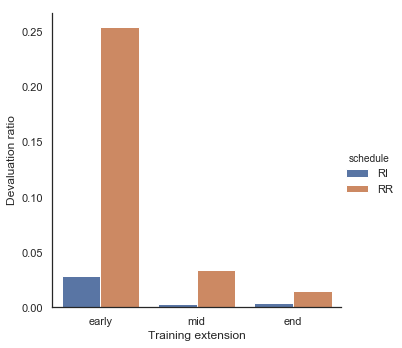

In [142]:
sns.set(style='white', font_scale=1)

g = sns.catplot(x="session", y="dev_ratio",
                hue="schedule", kind="bar", dodge=True,
                data=df_prob_types, ci=False)

(g.set_axis_labels("Training extension", "Devaluation ratio")
 .set_xticklabels(["early", "mid", "end"]))

# axis.set(ylim=(-.1, 1), ylabel='Response strength', xlabel='Session')
# plt.legend(loc='right')
plt.savefig('sims/dev_ratio_early_late.png', dpi=600)

In [8]:
x=3

In [14]:
# create df to plot 
data = {'Schedule':  ['ratio']*2+['interval']*2,
        'condition': ['valued', 'devalued']*2,
        'Response rate': [15.75, 6.399, 6.786, 6.505],
        }

df_Dickinson1983 = DataFrame(data, columns = ['Schedule', 'condition', 'Response rate'])
df_Dickinson1983

,Schedule,condition,Response rate
0,ratio,valued,15.750
1,ratio,devalued,6.399
2,interval,valued,6.786
3,interval,devalued,6.505


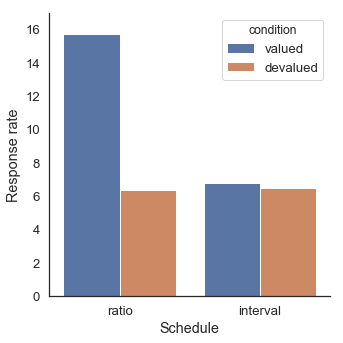

In [21]:
sns.set(style='white', font_scale=1.2)
g = sns.catplot(x="Schedule",
                y="Response rate",
                kind="bar",
                dodge=True,
                hue="condition",
                data=df_Dickinson1983,
                ci=False, 
                legend_out=False)

(g.set_axis_labels("Schedule", "Response rate")
 .set(ylim=(0,17)))

plt.savefig('sims/Dickinson1983.png', dpi=800)

# CHOICE (Kosaki and Dickinson, 2010)

In [154]:
# Instantiate exp and schedule classes
exp = Exp(nLevers=1, nCycles=2000, nRats=500, nSessions=10) # define exp object
schedule = Schedule(name='RI', parameter=15, m=5) # define schedule object

rnfFlag, cont_degradation, choice_training = False, False, True # flag to deliver reinforcer in RI; bool for cont_degradation training 

# create csv to save results 
csv_file, writer_object, csv_file2, writer_object2 = create_csv()

# set probability of engagement = prob of disengagement 
prob_engaged, engaged = .1, False # this is equivalent to Kosaki and Dickinson's average time spent on each lever

# Now we take each rat and simulate cycles
for rat in xrange(int(exp.nRats)): # this is equivalent to repetition of the experiment
    #print("Rat: %i")%rat

    # initialise variables for this rat
    session, T, ph, pi, pg, p, nRespCycle, nReinfCycle, nResp, nReinf, \
    rnfs_per_session, cycle, respPerMin = init_values_this_rat()

    for cycle_number in xrange(exp.nCycles):        
        
        # finish this rat if number of sessions is the programmed one
        if session == exp.nSessions:
            break
        
        # initialise variables for this cycle
        T, resp, reinf, IRT, resp_time, rnf_time, \
        n_resp_since_last_rnf, engaged_vec = init_values_this_cycle()
        
        # This loops for every second
        for t in xrange(int(T[cycle_number])):
            
            # bait reinforcer according to schedule parameter
            if schedule.name in ['RI', 'RIplus']:
                if not rnfFlag: # this flags the reinf for RI
                    rnfFlag = np.random.binomial(1, 1/schedule.parameter) # if equal to 1, set the reinforcer.
            
            # Now generate the resp in this second
            if choice_training:
                if not engaged:
                    resp[t] = 0 # can't be ignored because it's already 0, but good for understanding the code
                    engaged_vec[t] = engaged
                    engaged = np.random.binomial(1, prob_engaged)
                elif engaged: # now it's engaged in responding
                    resp[t] = np.random.binomial(1, cycle.prob)
                    engaged_vec[t] = engaged
                    engaged = np.random.binomial(1, prob_engaged)
            else:
                resp[t] = np.random.binomial(1, cycle.prob)
            
            if resp[t]: # if a response, run the giveRnf method to see whether it is reinforced
                schedule.giveRnf()
                nResp += 1
                
            # for contingency degradation
            if cont_degradation:
                if not resp[t]: # if not responding, then deliver reinforcer with same probability
                    reinf[t] = np.random.binomial(1, 1/schedule.parameter)
        
        #calculate probs for each system, then sum 
        pg[cycle_number] = cycle.C*calculate_corr() + (1-cycle.C)*pg[cycle_number-1] if cycle > 0 else calculate_corr() # prob g-d system
        
        if np.isnan(pg[cycle_number]): # if NA then fill with zero # this is the previous rule: pg[cycle_number-1]; replaced by mean pg
            pg[cycle_number] = 0#pg[cycle_number-1] 
            
#         if p[cycle_number-1] == 1: # at asymptote, g must be zero by definition
#             pg[cycle_number] = 0
            
        # This is h
        ph[cycle_number], pi[cycle_number] = calculate_h(a=.02, b=.0000001) # if cycle_number !=0 else calculate_h() 
        
        if cycle_number == 0: # start with some pretraining value for pg and ph
            pg[cycle_number], ph[cycle_number], pi[cycle_number] = .8, .1, .1
        
        # p = h + g - hg
        p[cycle_number] = sigmoid(cycle.D*ph[cycle_number] + pg[cycle_number]) # - pi[cycle_number]) # - cycle.D*ph[cycle_number]*pg[cycle_number]     

        # now assign these values for next cycle
        cycle.winNumber = 1 # only one window if not first cycle; above, the winNumber for first cycle was defined
        cycle.prob = p[cycle_number] if p[cycle_number] > 0 else 0 # set total prob of resp for each cycle 
        
        # write prob for each CYCLE and rat (not each second)
        save_cycle_data()

csv_file.close()
csv_file2.close()

#lineplot(schedule.name+'_'+str(schedule.parameter))

### Plot choice

In [145]:
def bplot_kosaki(df):
    ''' this function plots the two groups of kosaki and dickinson 2010.
    Argument is dataframe. The rest is the same for both plots. '''
    sns.set(style='white', font_scale=1.2)
    g = sns.catplot(x="prob_type", y="prob_value",
                hue="prob_type", kind="bar", dodge=False,
                data=df, ci=False)

    (g.set_axis_labels("Probability type", "Response strength, response probability")
     .set(ylim=(0,1)))

# axis.set(ylim=(-.1, 1), ylabel='Response strength', xlabel='Session')
# plt.legend(loc='right')
#plt.savefig('sims/RI_14_non_contingent_end_training.png', dpi=800)

In [152]:
df_non_contingent = pd.read_csv("sims/RI_14.csv")

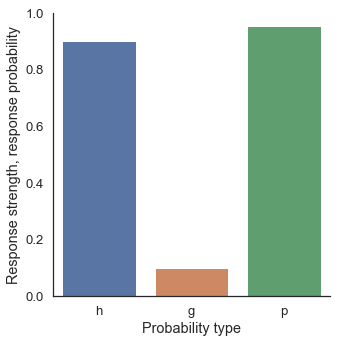

In [153]:
plot_non_contingent = bplot_kosaki(df_non_contingent[df_non_contingent["session"]==10])
plt.savefig('sims/RI_non_contingent.png', dpi=800)

In [155]:
df_choice = pd.read_csv('sims/RI_15.csv') # RI_15 is choice; RI_14 is non-contingent

# p1 = line_plot1(df_non_contingent)
#plt.savefig('sims/RI_non_contingent_learning.png', dpi=800)

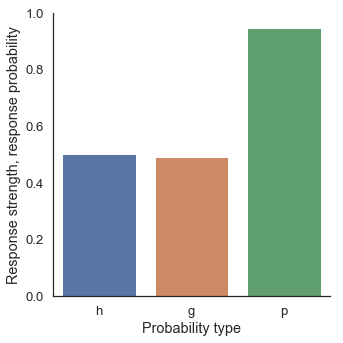

In [156]:
plot_choice = bplot_kosaki(df_choice[df_choice["session"]==10])
plt.savefig('sims/RI_choice.png', dpi=800)

In [168]:
df_choice_session10 = df_choice[df_choice["session"]==10]
df_choice_session10.groupby(['prob_type'], as_index=False).mean()


,prob_type,session,prob_value,rat,parameter
0,g,10.0,0.491227,249.5,15.0
1,h,10.0,0.503882,249.5,15.0
2,p,10.0,0.946983,249.5,15.0


In [170]:
dev_ratio_choice = sigmoid(.491227)/.946983
dev_ratio_choice

0.26615681079522635

In [171]:
df_non_contingent_session10 = df_non_contingent[df_non_contingent["session"]==10]
df_non_contingent_session10.groupby(['prob_type'], as_index=False).mean()



,prob_type,session,prob_value,rat,parameter
0,g,10.0,0.098907,249.5,14.0
1,h,10.0,0.902517,249.5,14.0
2,p,10.0,0.954132,249.5,14.0


In [173]:
dev_ratio_non_contingent = sigmoid(.098907)/.954132
dev_ratio_non_contingent

0.006938849203850023

In [12]:
# create df to plot 
data = {'group':  ['choice', 'nonContingent'],
        'dev_ratio': [.266, .007],
        }

df_kosaki2010_dev_ratio = DataFrame(data, columns = ['group','dev_ratio'])

df_kosaki2010_dev_ratio

,group,dev_ratio
0,choice,0.266
1,nonContingent,0.007


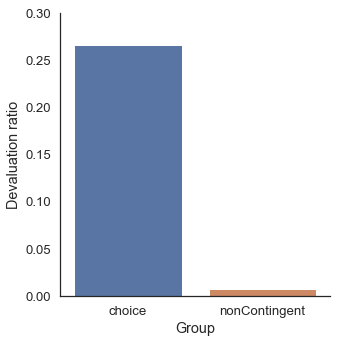

In [177]:
sns.set(style='white', font_scale=1.2)
g = sns.catplot(x="group", y="dev_ratio",
            kind="bar", dodge=False,
            data=df_kosaki2010_dev_ratio, ci=False)

(g.set_axis_labels("Group", "Devaluation ratio")
 .set(ylim=(0,.3)))

plt.savefig('sims/kosaki2010_dev_ratio.png', dpi=800)

Plot original data as devaluation ratio

In [311]:
kosaki2010_ori = pd.read_csv("kosaki2010.csv")
kosaki2010_ori

,group,cond_val,dev_ratio
0,choice,valued,0.48
1,choice,devalued,0.28
2,nonContingent,valued,0.47
3,nonContingent,devalued,0.49


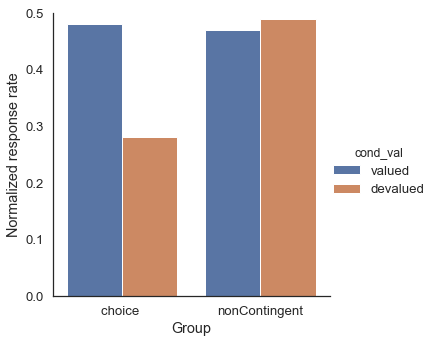

In [314]:
sns.set(style='white', font_scale=1.2)
g = sns.catplot(x="group", y="dev_ratio",
            kind="bar", dodge=True, hue="cond_val",
            data=kosaki2010_ori, ci=False, hue_order=["valued", "devalued"])

(g.set_axis_labels("Group", "Normalized response rate")
 .set(ylim=(0, .5)))

plt.savefig("sims/KosakiDickinson2010_ori.png", dpi=800)

In [306]:
kosaki_phases_means = kosaki2010_ori.groupby(["phase", "cond_val"], as_index=False).mean()
kosaki_phases_means

,phase,cond_val,resp_rate
0,extinction,devalued,9.275
1,extinction,valued,8.375
2,training,devalued,16.000
3,training,valued,14.100


In [307]:
kosaki2010_test = kosaki2010_ori[kosaki2010_ori.phase=="extinction"]
kosaki2010_test.head()

,group,training_ext,cond_val,resp_rate,phase
0,choice,ext1,valued,9.0,extinction
1,choice,ext1,devalued,10.0,extinction
2,nonContingent,ext1,valued,11.6,extinction
3,nonContingent,ext1,devalued,15.0,extinction
8,choice,ext2,valued,6.0,extinction


In [308]:
kosaki2010_test = kosaki2010_test.groupby(["group", "cond_val"], as_index=False).mean()

kosaki2010_test

,group,cond_val,resp_rate
0,choice,devalued,6.80
1,choice,valued,7.50
2,nonContingent,devalued,11.75
3,nonContingent,valued,9.25


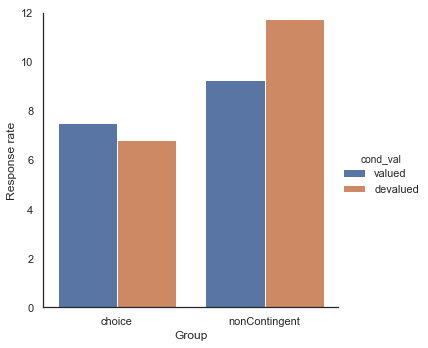

In [310]:
sns.set(style='white', font_scale=1)
g = sns.catplot(x="group", y="resp_rate",
            kind="bar", dodge=True, hue="cond_val",
            data=kosaki2010_test, ci=False, hue_order=["valued", "devalued"])

(g.set_axis_labels("Group", "Response rate")
 .set(ylim=(0,12)))

plt.savefig("sims/KosakiDickinson2010_ori.png", dpi=800)

# Extinction and contingency degradation after RR 5 training

To simulate a extinction session, we start using the value of $p$ obtained at the end of training in the previous simulations and suspend reinforcement. Since the prediction error is governed by the sum of p and h, and g stays constant, the decrease in h should continue to a negative value, so that $p=h+g-gh$ goes to zero and g is maintained, predicting the survival of g-d control across extinction.

In [133]:
#a = 0.005 # this is beta +
#b = 0.00005 # this is beta -

# def calculate_h(a, b):
#     ''' This is the Reinforcement Learning function for the habit system. 
#     In each time point, it updates the habit strength. 
#     In each cycle, it starts with the accumulated strength up to the previous cycle,(ph[cycle_number-1]) '''
    
#     h = np.zeros(int(T[cycle_number])) # t[cycle_number] = length of cycle
#     h[0] = ph[cycle_number-1] if cycle_number != 0 else 0
    
#     for t in xrange(int(T[cycle_number])-1): # for all  t in current cycle, until previous to last t
#         if resp[t] and reinf[t]:
#             h[t+1] = h[t] + a*(1 - (h[t]+ pg[cycle_number])) # + pg[cycle_number])) # - b*h[t]
#         elif resp[t] and not reinf[t]:
#             h[t+1] = h[t] - b*(h[t] + pg[cycle_number]) #- .01# b*h[t] #+ pg[cycle_number]) #(ph[cycle_number] + pg[cycle_number])
#         else: 
#             h[t+1] = h[t]
#     return h[-1]    

## Ratio schedule (MASTER)

In [41]:
# Instantiate exp and schedule classes
exp = Exp(nLevers=1, nCycles=2000, nRats=100, nSessions=20) # define exp object
schedule = Schedule(name='RR', parameter=5, m=5) # define schedule object

rnfFlag, cont_degradation, choice_training = False, True, False # flag to deliver reinforcer in RI; bool for cont_degradation training 

# create csv to save results 
csv_file, writer_object, csv_file2, writer_object2 = create_csv()

rnfProb = np.zeros([exp.nRats, exp.nSessions]) # this array saves the rnfProb for every session (after n reinforcers have been delivered)

# Now we take each rat and simulate cycles
for rat in xrange(int(exp.nRats)): # this is equivalent to repetition of the experiment
    #print("Rat: %i")%rat

    # initialise variables for this rat
    session, T, ph, pi, pg, p, nRespCycle, nReinfCycle, nResp, nReinf, \
    rnfs_per_session, cycle, respPerMin = init_values_this_rat()

    for cycle_number in xrange(exp.nCycles):        
        
        # finish this rat if number of sessions is the programmed one
        if session == exp.nSessions:
            break
        
        # initialise variables for this cycle
        T, resp, reinf, IRT, resp_time, rnf_time, \
        n_resp_since_last_rnf, engaged_vec = init_values_this_cycle()
        
        # This loops for every second
        for t in xrange(int(T[cycle_number])):
            
            # bait reinforcer according to schedule parameter
            if schedule.name in ['RI', 'RIplus']:
                if not rnfFlag: # this flags the reinf for RI
                    rnfFlag = np.random.binomial(1, 1/schedule.parameter) # if equal to 1, set the reinforcer.
            
            # Now generate the resp in this second
            resp[t] = np.random.binomial(1, cycle.prob)
            
            if resp[t]: # if a response, run the giveRnf method to see whether it is reinforced
                schedule.giveRnf()
                nResp += 1
            # for contingency degradation
            if cont_degradation:
                if not resp[t]: # if not responding, then deliver reinforcer with same probability
                    reinf[t] = np.random.binomial(1, 1/schedule.parameter)

        # calculate probs for each system, then sum 
        
        pg[cycle_number] = cycle.C*calculate_corr() + (1-cycle.C)*pg[cycle_number-1] if cycle > 0 else calculate_corr() # prob g-d system
        
        if np.isnan(pg[cycle_number]): # if NA then fill with zero # this is the previous rule: pg[cycle_number-1]; replaced by mean pg
            pg[cycle_number] = pg[cycle_number-1] 
            
#         if p[cycle_number-1] == 1: # at asymptote, g must be zero by definition
#             pg[cycle_number] = 0
            
        # This is h
        ph[cycle_number] = calculate_h(a=.02, b=.00001) # if cycle_number !=0 else calculate_h() 
        
        if cycle_number == 0: # start with some pretraining value for pg and ph
            pg[cycle_number], ph[cycle_number] = .7, .1
        
        # p = h + g - hg
        p[cycle_number] = sigmoid(cycle.D*ph[cycle_number] + pg[cycle_number]) # - pi[cycle_number]) # - cycle.D*ph[cycle_number]*pg[cycle_number]     

        # now assign these values for next cycle
        cycle.winNumber = 1 # only one window if not first cycle; above, the winNumber for first cycle was defined
        cycle.prob = p[cycle_number] if p[cycle_number] > 0 else 0 # set total prob of resp for each cycle 
        
        # write prob for each CYCLE and rat (not each second)
        save_cycle_data()

csv_file.close()
csv_file2.close()

#lineplot(schedule.name+'_'+str(schedule.parameter))

In [193]:
df_extinction = pd.read_csv('sims/RR_1000000_20-09-2019_17-10.csv') # RI_15 is choice; RI_16\4 is non-contingent
# df_extinction[df_extinction.cycle==df_extinction.cycle.max()].groupby(['prob_type']).mean()
# df_extinction.loc[df_extinction['prob_type'] == "ph" ] = "h"
# df_extinction.loc[df_extinction['prob_type'] == "pg" ] = "g"

# df_extinction[df_extinction["prob_type"]=="ph"] = "h"
# df_extinction[df_extinction["prob_type"]=="pg"] = "g"
df_extinction

,cycle,prob_type,prob_value,rat,schedule,parameter
0,0,ph,0.100000,0,RR,1000000
1,0,pg,0.800000,0,RR,1000000
2,0,p,0.952574,0,RR,1000000
3,1,ph,0.098381,0,RR,1000000
4,1,pg,0.800000,0,RR,1000000
5,1,p,0.951838,0,RR,1000000
6,2,ph,0.096766,0,RR,1000000
7,2,pg,0.800000,0,RR,1000000
8,2,p,0.951091,0,RR,1000000
9,3,ph,0.095063,0,RR,1000000


## Plot extinction 

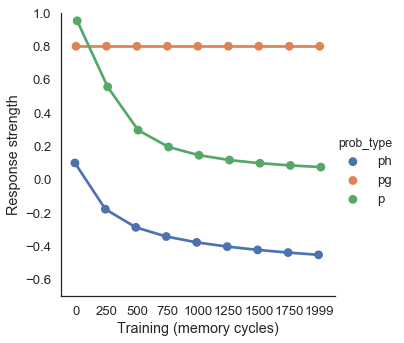

In [194]:
# lineplots for each system
#     sns.set(style='whitegrid', font_scale=.7)
# g = sns.pointplot(x='cycle', y='prob_`value', data=df_extinction[df_extinction.cycle>1900], dodge=True, hue='prob_type',
#                   linestyles=['-', '-', '-'], markers=['x','^','o'], scale=1)

sns.set(style='white', font_scale=1.2)
g = sns.catplot(x="cycle", y="prob_value",
            kind="point", dodge=True, hue="prob_type",
            data=df_extinction[df_extinction.cycle.isin([0, 250, 500, 750, 1000, 1250, 1500, 1750, 1999])], ci=False)

(g.set_axis_labels("Training (memory cycles)", "Response strength")
 .set(ylim=(-.7, 1)))

plt.savefig('sims/extinction.png', dpi=800)

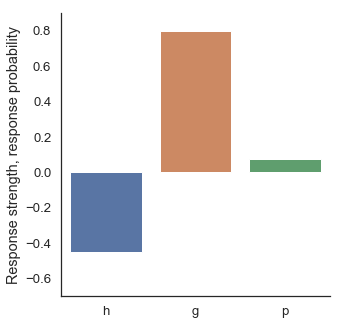

In [203]:
sns.set(style='white', font_scale=1.2)

g = sns.catplot(x="prob_type", y="prob_value",
            kind="bar", dodge=False, hue="prob_type",
            data=df_extinction[df_extinction["cycle"]==1999], ci=False)

(g.set_axis_labels("", "Response strength, response probability")
.set(ylim=(-.7, .9))
.set_xticklabels(["h", "g", "p"]))

plt.savefig('sims/extinction_bar.png', dpi=800)

In [201]:
df_rescorla1993 = pd.read_csv('rescorla_1993.csv')
df_rescorla1993

,cond_val,group,resp_rate
0,devalued,not_extinguished,7.253012
1,valued,not_extinguished,12.144578
2,devalued,extinguished,3.223561
3,valued,extinguished,9.614458


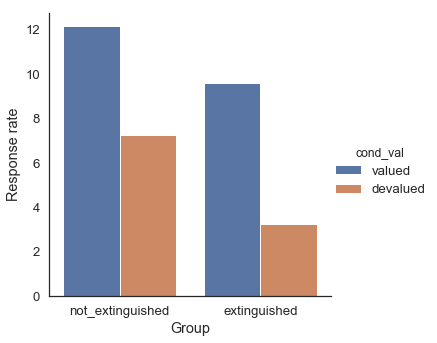

In [202]:
sns.set(style='white', font_scale=1.2)
g = sns.catplot(x="group", y="resp_rate", hue="cond_val",
               kind="bar", dodge=True, data=df_rescorla1993,
                hue_order=["valued", "devalued"])
(g.set_axis_labels("Group", "Response rate"))

plt.savefig('sims/rescorla1993.png', dpi=800)

# Plot non-contingent training

In [42]:
df_contingency_deg1 = pd.read_csv('sims/RR_5_23-01-2020_16-53.csv')

In [43]:
df_contingency_deg1.cycle.max()

1999

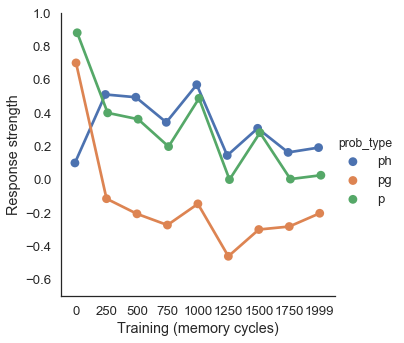

In [49]:
# lineplots for each system
#     sns.set(style='whitegrid', font_scale=.7)
# g = sns.pointplot(x='cycle', y='prob_`value', data=df_extinction[df_extinction.cycle>1900], dodge=True, hue='prob_type',
#                   linestyles=['-', '-', '-'], markers=['x','^','o'], scale=1)

sns.set(style='white', font_scale=1.2)
g = sns.catplot(x="cycle", y="prob_value",
            kind="point", dodge=True, hue="prob_type",
            data=df_contingency_deg1[df_contingency_deg1["cycle"].isin([0, 250, 500, 750, 1000, 1250, 1500, 1750, 1999])], ci=False)

(g.set_axis_labels("Training (memory cycles)", "Response strength")
 .set(ylim=(-.7, 1)))

plt.savefig('sims/cont_deg_after_ext_line.png', dpi=800)

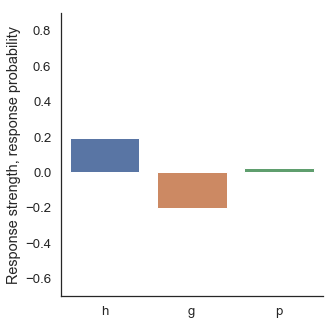

In [50]:
sns.set(style='white', font_scale=1.2)

g = sns.catplot(x="prob_type", y="prob_value",
            kind="bar", dodge=False, hue="prob_type",
            data=df_contingency_deg1[df_contingency_deg1["cycle"]==1999], ci=False)

(g.set_axis_labels("", "Response strength, response probability")
.set(ylim=(-.7, .9))
.set_xticklabels(["h", "g", "p"]))

plt.savefig('sims/cont_deg_after_training.png', dpi=800)

## Contingency degradation (Balleine & Dickinson, 1998)

We train rats under an RR-20 schedule and then degrade the contingency. The starting values are the sames as the pre-training above. 

In [227]:
p_cont_deg = df_contingency_deg1[(df_contingency_deg1["prob_type"]=="p") &
                    (df_contingency_deg1["session"]==7)].mean()["prob_value"]

p_non_cont_deg = df_contingency_deg[(df_contingency_deg["prob_type"]=="p") &
                    (df_contingency_deg["session"]==8)].mean()["prob_value"]

print p_cont_deg, p_non_cont_deg

0.19888395858467176 0.3248388662218503


In [244]:
# create dataframe
# create df to plot 
data = {'group':  ['different', 'same'],
        'Responses per min': [25.96, 11.32],
        }

df_BalleineDickinson1998 = DataFrame(data, columns = ['group','Responses per min'])

df_BalleineDickinson1998

,group,Responses per min
0,different,25.96
1,same,11.32


In [236]:
data = {'group': ["different", "same"],
       "Response strength": [p_non_cont_deg, p_cont_deg]}

df_BalleineDickinson1998_sims = DataFrame(data, columns = ["group", "Response strength"])
df_BalleineDickinson1998_sims

,group,Response strength
0,different,0.324839
1,same,0.198884


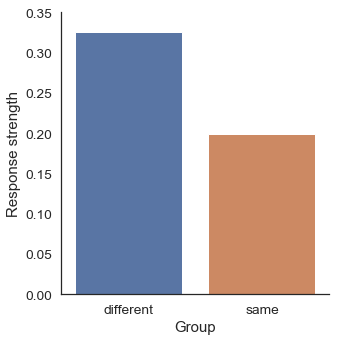

In [250]:
# this is the plot for the simulations of cont degradation; below we plot the original data
sns.set(style='white', font_scale=1.25)

g = sns.catplot(x="group", y="Response strength",
            kind="bar", dodge=True,
            data=df_BalleineDickinson1998_sims,
                ci=False)

(g.set_axis_labels("Group", "Response strength")
 .set(ylim=(0, .35)))

plt.savefig('sims/BalleineDickinson1998_sims.png', dpi=800)

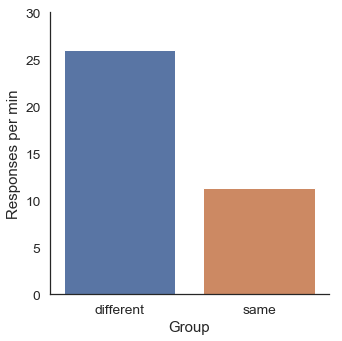

In [254]:
sns.set(style='white', font_scale=1.25)

g = sns.catplot(x="group", y="Responses per min",
            kind="bar", dodge=True,
            data=df_BalleineDickinson1998,
                ci=False)

(g.set_axis_labels("Group", "Responses per min")
 .set(ylim=(0, 30)))

plt.savefig("sims/BalleineDickinson1998_ori.png", dpi=800)

df_contingency_deg is the original one; df_contingency_deg1 is the experimental one with the degradation done.

## END OF PAPERS' SIMULATIONS

#################################################################################################

# Create plots extracting data from thesis' plots

Mazur 1983 experiment for different ratio requirements

In [31]:
df_Mazur1983 = pd.read_csv("Mazur1983.csv")
df_Mazur1983

,rat,ratio,resp_rate
0,1,10,65.050000
1,1,20,86.030963
2,1,40,64.292931
3,1,80,45.646748
4,2,10,99.395620
5,2,20,110.893060
6,2,40,62.780859
7,2,80,25.831911
8,3,10,46.966489
9,3,20,54.234504


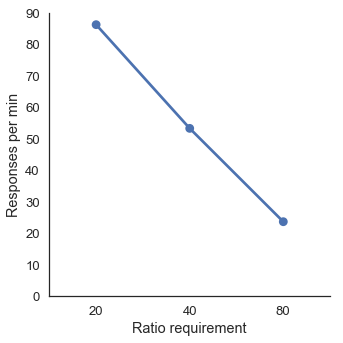

In [35]:
# lineplots for each system
#     sns.set(style='whitegrid', font_scale=.7)
# g = sns.pointplot(x='cycle', y='prob_`value', data=df_extinction[df_extinction.cycle>1900], dodge=True, hue='prob_type',
#                   linestyles=['-', '-', '-'], markers=['x','^','o'], scale=1)

sns.set(style='white', font_scale=1.2)
g = sns.catplot(x="ratio", y="resp_rate",
            kind="point", dodge=True,
            data=df_Mazur1983[df_Mazur1983["ratio"]!=10], ci=False)

(g.set_axis_labels("Ratio requirement", "Responses per min")
 .set(ylim=(0, 90)))

plt.savefig('sims/mazur1983_ori.png', dpi=800)

Simulations

In [27]:
# these were extracted manually from the original plots using webplotdigitizer
data = {"ratio": [5,10,20,30],
        "resp_rate": [0.361,0.293,0.195,0.150]}

df_Mazur1983_sims = pd.DataFrame(data, columns=["ratio", "resp_rate"])
df_Mazur1983_sims

,ratio,resp_rate
0,5,0.361
1,10,0.293
2,20,0.195
3,30,0.150


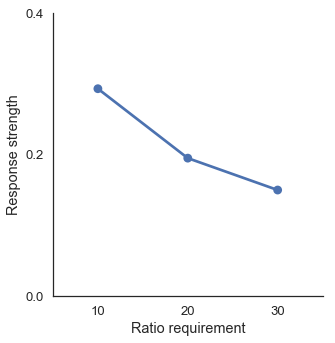

In [29]:
#     sns.set(style='whitegrid', font_scale=.7)
# g = sns.pointplot(x='cycle', y='prob_`value', data=df_extinction[df_extinction.cycle>1900], dodge=True, hue='prob_type',
#                   linestyles=['-', '-', '-'], markers=['x','^','o'], scale=1)

sns.set(style='white', font_scale=1.2)
g = sns.catplot(x="ratio", y="resp_rate",
            kind="point", dodge=True,
            data=df_Mazur1983_sims[df_Mazur1983_sims["ratio"]!=5], ci=False)

(g.set_axis_labels("Ratio requirement", "Response strength")
 .set(ylim=(0, .4))
.set(yticks=(0,.2,.4)))

plt.savefig('sims/mazur1983_sims.png', dpi=1000)

## Catania and Reynolds 1968

In [8]:
catania1968_ori = pd.read_csv("catania1968_ori.csv")
catania1968_ori["rnf_sec"] = catania1968_ori["rnf_hr"]/3600
catania1968_ori["interval"] = 1/catania1968_ori["rnf_sec"]

catania1968_ori

,id,rnf_hr,resp_min,rnf_sec,interval
0,1,4,38.4,0.001111,900.000000
1,1,13,72.2,0.003611,276.923077
2,1,33,86.0,0.009167,109.090909
3,1,78,98.3,0.021667,46.153846
4,1,153,108.4,0.042500,23.529412
5,1,298,116.4,0.082778,12.080537
6,2,8,32.6,0.002222,450.000000
7,2,15,32.8,0.004167,240.000000
8,2,23,69.6,0.006389,156.521739
9,2,79,62.1,0.021944,45.569620


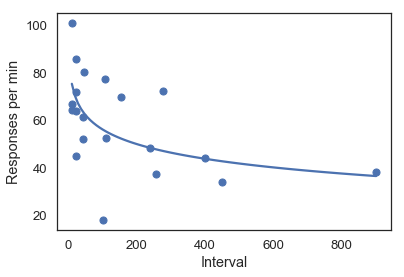

In [10]:
#     sns.set(style='whitegrid', font_scale=.7)
# g = sns.pointplot(x='cycle', y='prob_`value', data=df_extinction[df_extinction.cycle>1900], dodge=True, hue='prob_type',
#                   linestyles=['-', '-', '-'], markers=['x','^','o'], scale=1)

sns.set(style='white', font_scale=1.2)

# g = sns.lmplot(x='rnf_hr', # Horizontal axis
#            y='resp_min', # Vertical axis
#            data=catania1968_ori, # Data source
#            fit_reg=True), # Don't fix a regression line
# #            hue="id", # Set color
# #            scatter_kws={"marker": "D", # Set marker style
# #                         "s": 100}) # S marker size

g = sns.regplot(x="interval", y="resp_min", data=catania1968_ori, 
                 x_estimator=np.mean, logx=True, truncate=True, ci=None)

# g = sns.scatterplot(x="interval", y="resp_min",
#              data=catania1968_ori)

plt.xlabel("Interval")
plt.ylabel("Responses per min")

# (g.set_axis_labels("Outcome rate", "Responses per min")
#  .set(ylim=(0, 120)))

plt.savefig('sims/catania1968_ori.png', dpi=1000)

In [14]:
bradshaw1981_sims = pd.read_csv("catania1968_sim.csv")
bradshaw1981_sims

,interval,resp_strength
0,10,0.195266
1,30,0.125444
2,60,0.081657
3,90,0.049704


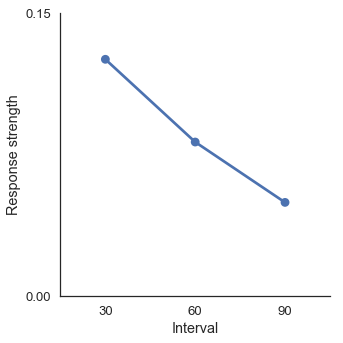

In [18]:
sns.set(style='white', font_scale=1.2)
g = sns.catplot(x="interval", y="resp_strength",
            kind="point", dodge=True,
            data=bradshaw1981_sims[bradshaw1981_sims["interval"]!=10], ci=False)

(g.set_axis_labels("Interval", "Response strength")
 .set(ylim=(0, .15))
.set(yticks=(0,.15)))

plt.savefig('sims/bradshaw1981_sims.png', dpi=1000)

## Reed 2001

In [18]:
reed2001_ori = pd.read_csv("reed2001_ori.csv")
reed2001_ori["resp_min"] = reed2001_ori["prob_resp"]*60
reed2001_ori

,schedule,prob_resp,resp_min
0,ratio,0.60,36.0
1,interval,0.31,18.6


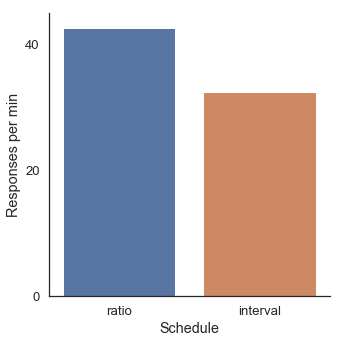

In [374]:
sns.set(style='white', font_scale=1.2)
g = sns.catplot(x="schedule", y="resp_min",
            kind="bar", dodge=True,
            data=reed2001_ori, ci=False)

(g.set_axis_labels("Schedule", "Responses per min")
 .set(ylim=(0, 45))
.set(yticks=(0,20,40)))

plt.savefig('sims/reed2001_ori.png', dpi=1000)

In [19]:
reed2001_sim = pd.read_csv("reed2001_sim.csv")
# reed2001_ori["resp_min"] = reed2001_ori["prob_resp"]*60
reed2001_sim

,schedule,resp_strength
0,ratio,0.51
1,interval,0.28


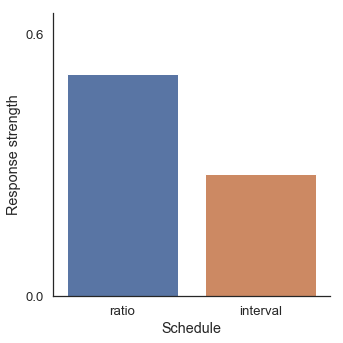

In [21]:
sns.set(style='white', font_scale=1.2)
g = sns.catplot(x="schedule", y="resp_strength",
            kind="bar", dodge=True,
            data=reed2001_sim, ci=False)

(g.set_axis_labels("Schedule", "Response strength")
 .set(ylim=(0, .65))
.set(yticks=(0,.6)))

plt.savefig('sims/reed2001_sim.png', dpi=1000)

## Dickinson et al. 1992

In [19]:
dickinson1992_ori = pd.read_csv("dickinson1992_ori.csv")
# reed2001_ori["resp_min"] = reed2001_ori["prob_resp"]*60
dickinson1992_ori

,delay,resp_min
0,16,6.6
1,32,4.4
2,64,0.3


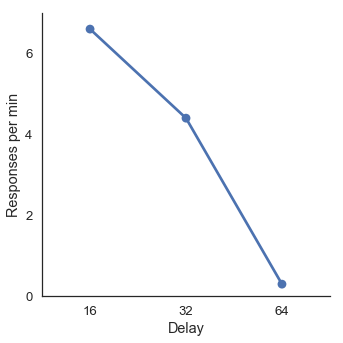

In [22]:
sns.set(style='white', font_scale=1.2)
g = sns.catplot(x="delay", y="resp_min",
            kind="point",
            data=dickinson1992_ori, ci=False)

(g.set_axis_labels("Delay", "Responses per min")
 .set(ylim=(0, 7))
.set(yticks=(0,2,4,6)))
# .set(title="Data"))

plt.savefig('sims/dickinson1992_ori.png', dpi=1000)

In [23]:
dickinson1992_sim = pd.read_csv("dickinson1992_sim.csv")
# reed2001_ori["resp_min"] = reed2001_ori["prob_resp"]*60
dickinson1992_sim

,delay,resp_strength
0,16,0.637
1,32,0.160
2,64,0.062


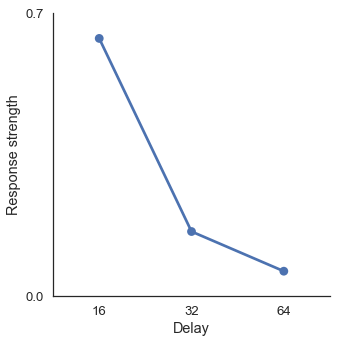

In [24]:
sns.set(style='white', font_scale=1.2)
g = sns.catplot(x="delay", y="resp_strength",
            kind="point", dodge=True,
            data=dickinson1992_sim, ci=False)

(g.set_axis_labels("Delay", "Response strength")
 .set(ylim=(0, .7))
.set(yticks=(0,.7)))

plt.savefig('sims/dickinson1992_sim.png', dpi=1000)

## Adams 1982 pre-training

Here we create the first memory with free outcomes and then run an RR training.

In [139]:
def init_values_this_cycle(p_rnf):
    ''' initialize the vectors for each cycle.
    For Adams study, we generate free reinforcers with prob p_rnf for the first cycle'''
   # length of each cycle. 1st cycle has length = winlength*winNumber; 
    #the following ones are just 1 window long
    T[cycle_number] = cycle.winLength*cycle.winNumber if cycle != 0 else \
    cycle.winLength 

    if cycle_number == 0: # for 1st cycle, long cycle, then just one window long
        resp = np.zeros(cycle.winLength*cycle.winNumber)
        reinf = np.random.binomial(1, p_rnf, cycle.winLength*cycle.winNumber) # change here p_rnf if we don't want Adams' 1982
        engaged_vec =  np.zeros(cycle.winLength*cycle.winNumber)            
    else:
        resp, reinf, engaged_vec = np.zeros(int(T[cycle_number])), np.zeros(int(T[cycle_number])), np.zeros(int(T[cycle_number])) 
    IRT, resp_time, rnf_time, n_resp_since_last_rnf = [], [], [0], 0
    
    return T, resp, reinf, IRT, resp_time, rnf_time, n_resp_since_last_rnf, engaged_vec

In [181]:
# Instantiate exp and schedule classes
exp = Exp(nLevers=1, nCycles=2000, nRats=100, nSessions=20) # define exp object
schedule = Schedule(name='RR', parameter=10, m=5) # define schedule object

rnfFlag, cont_degradation, choice_training = False, False, False # flag to deliver reinforcer in RI; bool for cont_degradation training 

# create csv to save results 
csv_file, writer_object, csv_file2, writer_object2 = create_csv()

rnfProb = np.zeros([exp.nRats, exp.nSessions]) # this array saves the rnfProb for every session (after n reinforcers have been delivered)

# Now we take each rat and simulate cycles
for rat in xrange(int(exp.nRats)): # this is equivalent to repetition of the experiment
    #print("Rat: %i")%rat

    # initialise variables for this rat
    session, T, ph, pg, p, nRespCycle, nReinfCycle, nResp, nReinf, \
    rnfs_per_session, cycle, respPerMin = init_values_this_rat()
    
    # replace cycle object for first cycle with a long memory size
    cycle = Cycle(prob=0.01, winNumber=200, winLength=20, D=1, C=.5) # C is weight for correlations; D is drive for habit system
    
    for cycle_number in xrange(exp.nCycles):        
        
        # finish this rat if number of sessions is the programmed one
        if session == exp.nSessions:
            break
        
        # initialise variables for this cycle
        T, resp, reinf, IRT, resp_time, rnf_time, \
        n_resp_since_last_rnf, engaged_vec = init_values_this_cycle(p_rnf=0.2)
        
        # This loops for every second
        for t in xrange(int(T[cycle_number])):
            
            # bait reinforcer according to schedule parameter
            if schedule.name in ['RI', 'RIplus']:
                if not rnfFlag: # this flags the reinf for RI
                    rnfFlag = np.random.binomial(1, 1/schedule.parameter) # if equal to 1, set the reinforcer.
            
            # Now generate the resp in this second
            resp[t] = np.random.binomial(1, cycle.prob)
            
            if resp[t]: # if a response, run the giveRnf method to see whether it is reinforced
                schedule.giveRnf()
                nResp += 1
            # for contingency degradation
            if cont_degradation:
                if not resp[t]: # if not responding, then deliver reinforcer with same probability
                    reinf[t] = np.random.binomial(1, 1/schedule.parameter)

        # calculate probs for each system, then sum 
        
        # this is g
        pg[cycle_number] = cycle.C*calculate_corr() + (1-cycle.C)*pg[cycle_number-1] if cycle_number > 0 else \
       calculate_corr() # prob g-d system
        
        if np.isnan(pg[cycle_number]): # if NA then fill with zero # this is the previous rule: pg[cycle_number-1]; replaced by mean pg
            pg[cycle_number] = pg[cycle_number-1] 
        #elif pg[cycle_number]<0:
        #    pg[cycle_number] = 0 # pg[cycle_number-1] - .1*pg[cycle_number-1]
        
        # This is h
        ph[cycle_number] = calculate_h(a=.005, b=.0001) # if cycle_number !=0 else calculate_h() 
        
        if cycle_number == 0: # start with some pretraining value for pg and ph
            pg[cycle_number], ph[cycle_number] = 0.7, 0.1
        
        # p = h + g - hg
        p[cycle_number] = cycle.D*ph[cycle_number] + pg[cycle_number] - abs(cycle.D*ph[cycle_number]*pg[cycle_number])
        
#         if p[cycle_number] < 0:
#             p[cycle_number] = 0
#         p[cycle_number] = cycle.D*ph[cycle_number] + pg[cycle_number] - cycle.D*ph[cycle_number]*pg[cycle_number]      
        #print('ph = %g, pg = %g, p = %g')%(ph[cycle_number], pg[cycle_number], p[cycle_number])         
        
        # now assign these values for next cycle
        cycle.winNumber = 1 # only one window if not first cycle; above, the winNumber for first cycle was defined
        cycle.prob = p[cycle_number] if p[cycle_number] > 0 else 0 # set total prob of resp for each cycle 
        
        # write prob for each CYCLE and rat (not each second)
        save_cycle_data()

csv_file.close()
csv_file2.close()

#lineplot(schedule.name+'_'+str(schedule.parameter))

Here we do the training. It's a ratio simulation with the first cycle filled of reinforcers.

In [169]:
df_non_pre_training = pd.read_csv('sims/RR_10.csv')
df_non_pre_training.tail()

,session,prob_type,prob_value,rat,schedule,parameter
5995,19,g,0.279272,99,RR,10
5996,19,p,0.628277,99,RR,10
5997,20,h,0.497729,99,RR,10
5998,20,g,0.268584,99,RR,10
5999,20,p,0.632631,99,RR,10


In [179]:
def bplot_adams1982(df, kind="bar"):
    sns.set(style='white', font_scale=1.2)

    g = sns.catplot(x="prob_type",
                    y="prob_value",
                    kind="bar",
                    hue="prob_type",
                    dodge=False,
                    data=df,
                    ci=False)

    (g.set_axis_labels(" ", "Response strength")
     .set(ylim=(0, .8))
    .set(yticks=(0, .4, .8)))


Plot non-pre-trained group

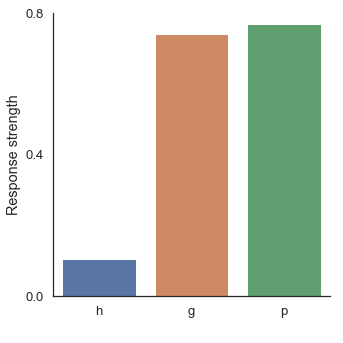

In [184]:
g = bplot_adams1982(df_non_pre_training[df_non_pre_training["session"]==1])


Plot pre-trained group

In [182]:
df_pre_training = pd.read_csv('sims/RR_10.csv')
df_pre_training.tail()

,session,prob_type,prob_value,rat,schedule,parameter
5995,19,g,0.212933,99,RR,10
5996,19,p,0.659070,99,RR,10
5997,20,h,0.575946,99,RR,10
5998,20,g,0.208127,99,RR,10
5999,20,p,0.664203,99,RR,10


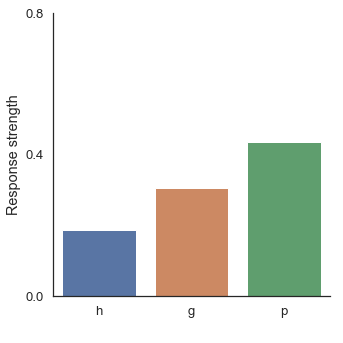

In [183]:
g = bplot_adams1982(df_pre_training[df_pre_training["session"]==1])

In [192]:
df_pre_training_means = df_pre_training[df_pre_training["session"]==1].groupby("prob_type", as_index=False).mean()
df_pre_training_means

,prob_type,session,prob_value,rat,parameter
0,g,1.0,0.304867,49.5,10.0
1,h,1.0,0.187045,49.5,10.0
2,p,1.0,0.435524,49.5,10.0


In [201]:
# df_pre_training_means[df_pre_training_means["prob_type"]=="g"]["prob_value"]

0    0.304867
Name: prob_value, dtype: float64

In [203]:
dev_ratio_pre_training = df_pre_training_means[df_pre_training_means["prob_type"]=="g"]["prob_value"] / df_pre_training_means[df_pre_training_means["prob_type"]=="p"]["prob_value"]

In [204]:
# do the same as above for non_pre_trained dataframe. Then plot the two dev_ratios.

df_non_pre_training_means = df_non_pre_training[df_non_pre_training["session"]==1].groupby("prob_type", as_index=False).mean()
df_non_pre_training_means

,prob_type,session,prob_value,rat,parameter
0,g,1.0,0.742227,49.5,10.0
1,h,1.0,0.105530,49.5,10.0
2,p,1.0,0.770158,49.5,10.0


In [206]:
dev_ratio_non_pre_training = df_non_pre_training_means[df_non_pre_training_means["prob_type"]=="g"]["prob_value"] / df_non_pre_training_means[df_non_pre_training_means["prob_type"]=="p"]["prob_value"]

In [208]:
dev_ratio_non_pre_training = .74/.77
dev_ratio_pre_training = .30/.44

In [209]:
data = {"group": ["pre_trained", "control"],
       "dev_ratio": [dev_ratio_pre_training, dev_ratio_non_pre_training]}

df_adams1982_dev_ratio = DataFrame(data, columns=["group", "dev_ratio"])
df_adams1982_dev_ratio

,group,dev_ratio
0,pre_trained,0.681818
1,control,0.961039


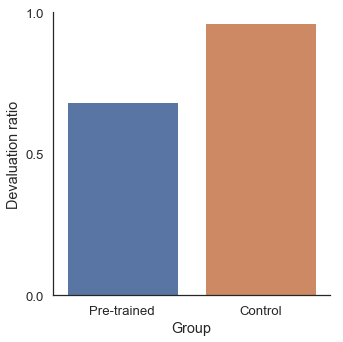

In [219]:
sns.set(style='white', font_scale=1.2)

g = sns.catplot(x="group",
                y="dev_ratio",
                kind="bar",
                dodge=True,
                data=df_adams1982_dev_ratio,
                ci=False)

(g.set_axis_labels("Group", "Devaluation ratio")
 .set(ylim=(0, .1))
.set(yticks=(0, .5, 1))
.set_xticklabels(["Pre-trained", "Control"])
)

plt.savefig("adams1982_sim.png", dpi=1000)

In [223]:
# this is adams original result
adams1982_ori = pd.read_csv("adams1982_ori")
adams1982_ori

,group,relative_resp_rate,cond_val
0,control,0.089538,deval
1,control,0.290769,val
2,pre_trained,0.229846,deval
3,pre_trained,0.250154,val


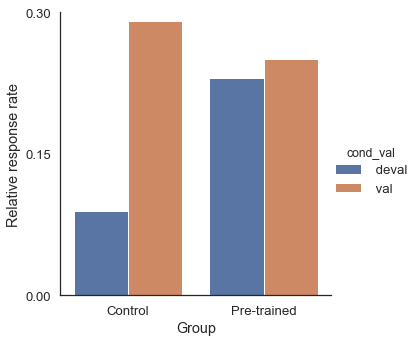

In [228]:
sns.set(style='white', font_scale=1.2)

g = sns.catplot(x="group",
                y="relative_resp_rate",
                kind="bar",
                hue="cond_val",
                dodge=True,
                data=adams1982_ori,
                ci=False)

(g.set_axis_labels("Group", "Relative response rate")
 .set(ylim=(0, .3))
.set(yticks=(0, .15, .3))
.set_xticklabels(["Control", "Pre-trained"])
)

plt.savefig("adams1982_ori.png", dpi=1000)

In [230]:
dev_ratio_pre_training_ori = (.25-.23)/.25
dev_ratio_control_ori = (.29-.09)/.29

In [231]:
data = {"Group": ["Pre-trained", "Control"],
       "Devaluation ratio": [dev_ratio_pre_training_ori, dev_ratio_control_ori]}

adams1982_ori_dev_ratio = DataFrame(data, columns=["Group", "Devaluation ratio"])
adams1982_ori_dev_ratio 

,Group,Devaluation ratio
0,Pre-trained,0.080000
1,Control,0.689655


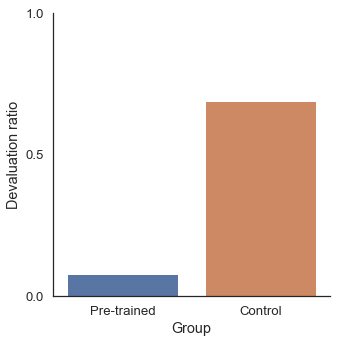

In [236]:
sns.set(style='white', font_scale=1.2)

g = sns.catplot(x="Group",
                y="Devaluation ratio",
                kind="bar",
                dodge=True,
                data=adams1982_ori_dev_ratio,
                ci=False)

(g.set_axis_labels("Group", "Devaluation ratio")
 .set(ylim=(0, 1))
.set(yticks=(0, .5, 1)))
# .set_xticklabels(["Control", "Pre-trained"])
# )

plt.savefig("adams1982_ori_dev_ratio.png", dpi=1000)

## Rescorla 1993 extinction (this is the correct one; the one above does not apply)

In [10]:
rescorla1993a_ori = pd.read_csv("Rescorla1993a")
rescorla1993a_ori

,group,resp_rate,condition
0,not_extinguished,12.15,valued
1,not_extinguished,7.08,devalued
2,extinguished,9.54,valued
3,extinguished,3.16,devalued


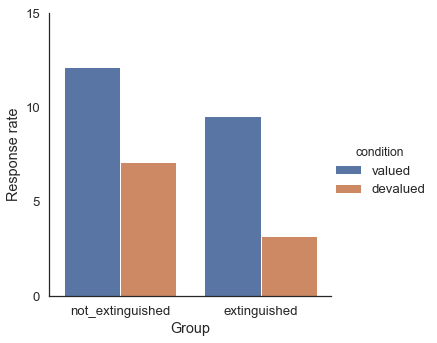

In [13]:

sns.set(style='white', font_scale=1.2)

g = sns.catplot(x="group",
                y="resp_rate",
                kind="bar",
                hue="condition",
                dodge=True,
                data=rescorla1993a_ori,
                ci=False)

(g.set_axis_labels("Group", "Response rate")
 .set(ylim=(0, 15))
.set(yticks=(0, 5, 10, 15)))
# .set_xticklabels(["Control", "Pre-trained"])
# )

plt.savefig("rescorla1993a.png", dpi=1000)

## Bradshaw 1981

In [9]:
bradshaw1981_ori = pd.read_csv("bradshaw1981_ori")
bradshaw1981_ori

,rat,interval,resp_rate
0,r66,10,79.4
1,r66,30,90.1
2,r66,53,56.0
3,r66,109,17.8
4,r67,10,69.7
5,r67,30,65.4
6,r67,53,54.4
7,r67,109,38.2
8,r68,10,62.6
9,r68,30,67.5


In [10]:
sns.set(style='white', font_scale=1.2)

g = sns.catplot(x="interval",
                y="resp_rate",
                kind="point",
                dodge=True,
                data=bradshaw1981_ori[bradshaw1981_ori["interval"]!=10],
                ci=False)

(g.set_axis_labels("Interval", "Response rate")
 .set(ylim=(0, 80))
.set(yticks=(0, 20, 40, 60, 80)))
# .set_xticklabels(["Control", "Pre-trained"])
# )

plt.savefig("bradshaw1981_ori.png", dpi=1000)

NameError: name 'bradshaw1981_ori' is not defined

## Feedback functions

In [11]:
b = np.linspace(.1, 15) # response rates in x axis

def interval_ff(T, a=1):
    '''T = interval parameter
       a = parameter as in prelec and staddon 1978'''
    y = b/(T*b + a)
    return y 

def ratio_ff(ratio):
    'n is the ratio parameter'
    y = (1/ratio)*b
    return y

y = ratio_ff(40)

In [22]:
# for ratio in [10,20,30,40]:
def plot_interval_ff():
    for interval in [10, 30, 60, 90]:
        plt.plot(b, interval_ff(interval, a=10), label=str(interval)+' s')
        plt.xlabel("Response rate")
        plt.ylabel("")
        hold(True)
        plt.title('')
        plt.legend()

def plot_ratio_ff():
    for ratio in [10, 20, 30, 50]:
        plt.plot(b, ratio_ff(ratio), label="prob = %12.2f" %(1/ratio))
        plt.xlabel("Response rate")
        plt.ylabel("Outcome rate")
        hold(True)
        plt.title('')
        plt.legend()


/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
/opt/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/opt/anaconda2/lib/python2.7/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


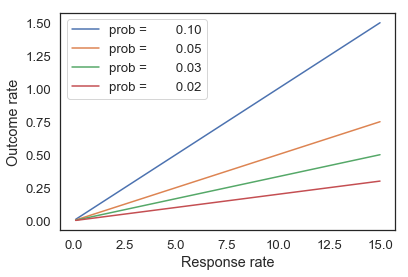

In [13]:

plot_ratio_ff()

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  import sys


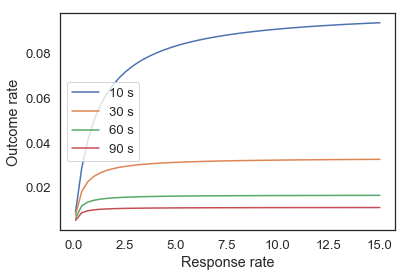

In [14]:
plot_interval_ff()

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  import sys


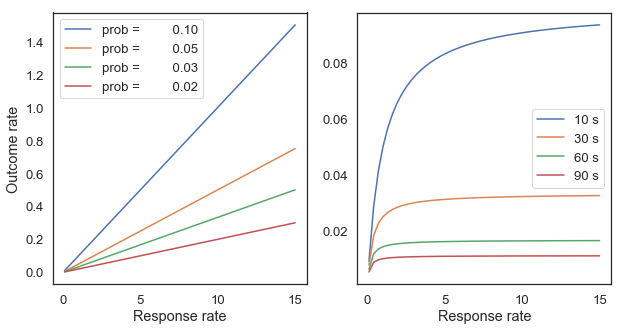

In [23]:
figsize(10,5)

plt.subplot(1, 2, 1)
plot_ratio_ff()
plt.subplot(1, 2, 2)
plot_interval_ff()

plt.savefig('sims/ff.png', dpi=600)

# Simulations for DeRusso et al. 2010

In [33]:
# Instantiate exp and schedule classes
exp = Exp(nLevers=1, nCycles=2000, nRats=30, nSessions=20) # define exp object
schedule = Schedule(name='FI', parameter=30, m=5) # define schedule object

rnfFlag, cont_degradation, choice_training = False, False, False # flag to deliver reinforcer in RI; bool for cont_degradation training 

# create csv to save results 
csv_file, writer_object, csv_file2, writer_object2 = create_csv()

rnfProb = np.zeros([exp.nRats, exp.nSessions]) # this array saves the rnfProb for every session (after n reinforcers have been delivered)

# Now we take each rat and simulate cycles
for rat in xrange(int(exp.nRats)): # this is equivalent to repetition of the experiment
    #print("Rat: %i")%rat

    # initialise variables for this rat
    session, T, ph, pi, pg, p, nRespCycle, nReinfCycle, nResp, nReinf, \
    rnfs_per_session, cycle, respPerMin = init_values_this_rat()

    for cycle_number in xrange(exp.nCycles):        
        
        # finish this rat if number of sessions is the programmed one
        if session == exp.nSessions:
            break
        
        # initialise variables for this cycle
        T, resp, reinf, IRT, resp_time, rnf_time, \
        n_resp_since_last_rnf, engaged_vec = init_values_this_cycle()
        
        k = 1 # index to start responding before each fixed interval
        
        # This loops for every second
        for t in xrange(int(T[cycle_number])):
            
            # bait reinforcer according to schedule parameter
            if schedule.name in ['RI', 'RIplus']:
                if not rnfFlag: # this flags the reinf for RI
                    rnfFlag = np.random.binomial(1, 1/schedule.parameter) # if equal to 1, set the reinforcer.
            elif schedule.name == 'FI':
                if t in np.arange(schedule.parameter, T[cycle_number], schedule.parameter): # equally spaced intervals
                    rnfFlag = 1
            
            # generate response 
            if t > (3/4)*k*schedule.parameter:
                resp[t] = np.random.binomial(1, cycle.prob)
            else:
                resp[t] = 0
            
            if resp[t]: # if a response, run the giveRnf method to see whether it is reinforced
                schedule.giveRnf()
                nResp += 1
            # for contingency degradation
            if cont_degradation:
                if not resp[t]: # if not responding, then deliver reinforcer with same probability
                    reinf[t] = np.random.binomial(1, 1/schedule.parameter)

        # calculate probs for each system, then sum 
        
        # this is g
        pg[cycle_number] = cycle.C*calculate_corr() + (1-cycle.C)*pg[cycle_number-1] if cycle_number > 0 else \
        calculate_corr() # prob g-d system
        
        if np.isnan(pg[cycle_number]): # if NA then fill with zero # this is the previous rule: pg[cycle_number-1]; replaced by mean pg
            pg[cycle_number] = 0 #pg[cycle_number-1] 
            
#         if p[cycle_number-1] : # at asymptote, g must be zero by definition
#             pg[cycle_number] = 0
    
        #elif pg[cycle_number]<0:
        #    pg[cycle_number] = 0 # pg[cycle_number-1] - .1*pg[cycle_number-1]
        
        # This is h
        ph[cycle_number], pi[cycle_number] = calculate_h(a=.02, b=.0000001) # if cycle_number !=0 else calculate_h() 
        
        if cycle_number == 0: # start with some pretraining value for pg and ph
            pg[cycle_number], ph[cycle_number], pi[cycle_number] = .8, .1, .1
        
        # p = h + g - hg
        p[cycle_number] = sigmoid(cycle.D*ph[cycle_number] + pg[cycle_number]) # - pi[cycle_number]) # - cycle.D*ph[cycle_number]*pg[cycle_number] 
                
#         p[cycle_number] = cycle.D*ph[cycle_number] + pg[cycle_number] - cycle.D*ph[cycle_number]*pg[cycle_number]      
        #print('ph = %g, pg = %g, p = %g')%(ph[cycle_number], pg[cycle_number], p[cycle_number])         
        
        # now assign these values for next cycle
        cycle.winNumber = 1 # only one window if not first cycle; above, the winNumber for first cycle was defined
        cycle.prob = p[cycle_number] if p[cycle_number] > 0 else 0 # set total prob of resp for each cycle 
        
        # write prob for each CYCLE and rat (not each second)
        save_cycle_data()

csv_file.close()
csv_file2.close()

#lineplot(schedule.name+'_'+str(schedule.parameter))

In [34]:
# Create merged dataFrame with master and yoked simulations
df_master = pd.read_csv('sims/FI_30.csv') 


In [35]:
sns.set(style='whitegrid', font_scale=.8)
p1 = line_plot1(df_master)
# plt.savefig('sims/RI_master.png', dpi=600)


ValueError: min() arg is an empty sequence

## Single-system (rate correlation) simulations 

This is a master ratio simulation. To simulate the single-system, we ignore the habit algorithm.

In [20]:
# Instantiate exp and schedule classes
exp = Exp(nLevers=1, nCycles=2000, nRats=100, nSessions=10) # define exp object
schedule = Schedule(name='RR', parameter=50, m=5) # define schedule object

rnfFlag, cont_degradation, choice_training = False, False, False # flag to deliver reinforcer in RI; bool for cont_degradation training 

# create csv to save results 
csv_file, writer_object, csv_file2, writer_object2 = create_csv()

rnfProb = np.zeros([exp.nRats, exp.nSessions]) # this array saves the rnfProb for every session (after n reinforcers have been delivered)

# Now we take each rat and simulate cycles
for rat in xrange(int(exp.nRats)): # this is equivalent to repetition of the experiment
    #print("Rat: %i")%rat

    # initialise variables for this rat
    session, T, ph, pi, pg, p, nRespCycle, nReinfCycle, nResp, nReinf, \
    rnfs_per_session, cycle, respPerMin = init_values_this_rat()

    for cycle_number in xrange(exp.nCycles):        
        
        # finish this rat if number of sessions is the programmed one
        if session == exp.nSessions:
            break
        
        # initialise variables for this cycle
        T, resp, reinf, IRT, resp_time, rnf_time, \
        n_resp_since_last_rnf, engaged_vec = init_values_this_cycle()
        
        # This loops for every second
        for t in xrange(int(T[cycle_number])):
            
            # bait reinforcer according to schedule parameter
            if schedule.name in ['RI', 'RIplus']:
                if not rnfFlag: # this flags the reinf for RI
                    rnfFlag = np.random.binomial(1, 1/schedule.parameter) # if equal to 1, set the reinforcer.
            
            # Now generate the resp in this second
            resp[t] = np.random.binomial(1, cycle.prob)
            
            if resp[t]: # if a response, run the giveRnf method to see whether it is reinforced
                schedule.giveRnf()
                nResp += 1
            # for contingency degradation
            if cont_degradation:
                if not resp[t]: # if not responding, then deliver reinforcer with same probability
                    reinf[t] = np.random.binomial(1, 1/schedule.parameter)

        # calculate probs for each system, then sum 
        
        pg[cycle_number] = cycle.C*calculate_corr() + (1-cycle.C)*pg[cycle_number-1] if cycle > 0 else calculate_corr() # prob g-d system
        
        if np.isnan(pg[cycle_number]): # if NA then fill with zero # this is the previous rule: pg[cycle_number-1]; replaced by mean pg
            pg[cycle_number] = pg[cycle_number-1] 
            
#         if p[cycle_number-1] == 1: # at asymptote, g must be zero by definition
#             pg[cycle_number] = 0
            
        # This is h
        ph[cycle_number] = 0 #calculate_h(a=.02, b=.00001) # if cycle_number !=0 else calculate_h() 
        
        if cycle_number == 0: # start with pretraining value for pg and ph
            pg[cycle_number], ph[cycle_number] = .8, 0
        
        # p = h + g - hg
        p[cycle_number] = sigmoid(cycle.D*ph[cycle_number] + pg[cycle_number]) # - pi[cycle_number]) # - cycle.D*ph[cycle_number]*pg[cycle_number]     

        # now assign these values for next cycle
        cycle.winNumber = 1 # only one window if not first cycle; above, the winNumber for first cycle was defined
        cycle.prob = p[cycle_number] if p[cycle_number] > 0 else 0 # set total prob of resp for each cycle 
        
        # write prob for each CYCLE and rat (not each second)
        save_cycle_data()

csv_file.close()
csv_file2.close()

#lineplot(schedule.name+'_'+str(schedule.parameter))

In [21]:
# Create merged dataFrame with master and yoked simulations
df_master = pd.read_csv('sims/RR_50.csv')
df_master.head()


,session,prob_type,prob_value,rat,schedule,parameter
0,1,h,0.000000,6,RR,50
1,1,g,0.288430,6,RR,50
2,1,p,0.042464,6,RR,50
3,1,h,0.000000,9,RR,50
4,1,g,0.086711,9,RR,50


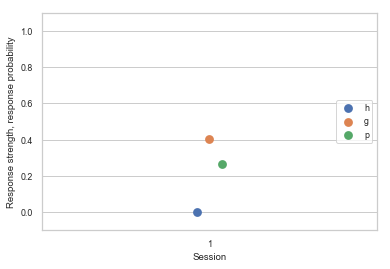

In [22]:
sns.set(style='whitegrid', font_scale=.8)
p1 = line_plot1(df_master)
# plt.savefig('sims/RI_master.png', dpi=600)

## END OF PLOTS FOR PAPER

In [13]:
np.arange(15, 400, 15)

array([ 15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195,
       210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360, 375, 390])

   session      prob prob_type schedule  dev_ratio
0        3  0.284779         g    ratio   0.492918
1        3  0.400982         h    ratio   0.492918
2        3  0.577741         p    ratio   0.492918
3       15  0.158756         g    ratio   0.183019
4       15  0.837971         h    ratio   0.183019


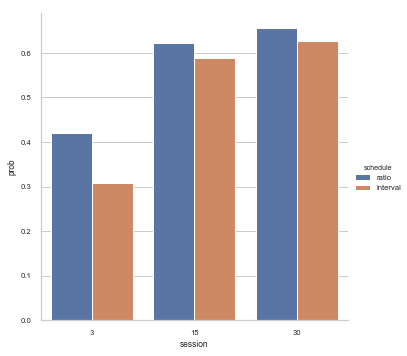

In [20]:
df = pd.read_csv("RR_early_late")
print(df.head())
g = sns.catplot(x="session", y="prob", hue="schedule", kind="bar", dodge=True, data=df, ci=False)

# save plot
plt.savefig(filename + '.png', dpi=800)
return g

# Plots 

## RR plot 

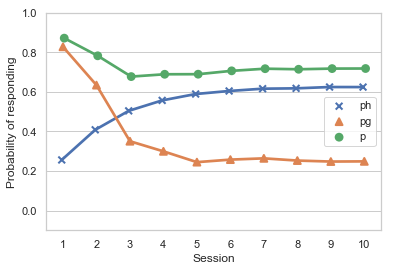

In [18]:
dataRR = pd.read_csv("RR_10.csv")
#dataRR.tail()
#print(pg[cycle_number-1], ph[cycle_number-1], p[cycle_number-1])
sns.set(style='whitegrid', font_scale=1)
g = sns.pointplot(x='session', y='prob_value', data=dataRR, dodge=True, hue='prob_type',
                  linestyles=['-', '-', '-'], ci=None, markers=['x','^','o'], scale=1)
axis = g.axes
axis.set(ylim=(-.1, 1), ylabel='Probability of responding', xlabel='Session')
plt.legend(loc='right')

In [17]:
print(resp, engaged_vector)

(array([1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))


this is the mock code for saving rnfProb every nth reinforcer (changed later to np.arrays)

## Master Ratio schedule 

In [60]:
# Instantiate exp and schedule classes
exp = Exp(nLevers=1, nCycles=1000, nRats=30, nSessions=10) # define exp object
schedule = Schedule(name='RR', parameter=10, m=5)

rnfFlag = False # flag to deliver reinforcer in RI

#model = 3

# Create csv files to save data
csv_file, writer_object, csv_file2, writer_object2 = create_csv()

#rnfProb_master_rat = rnfProb 

rnfProb = np.zeros([exp.nRats, exp.nSessions])  #deleted for yoking # this array saves the rnfProb for every session (after n reinforcers have been delivered)

# Now we take each rat and simulate cycles
for rat in xrange(int(exp.nRats)): # this is equivalent to repetition of the experiment
    #print("Rat: %i")%rat
    session = 0
    
    T = np.zeros(exp.nCycles) # length of each cycle    
    ph, pg, p = np.zeros(exp.nCycles), np.zeros(exp.nCycles), np.zeros(exp.nCycles) # probs for each system in each memory cycle
    nRespCycle, nReinfCycle = np.zeros(exp.nCycles), np.zeros(exp.nCycles) # nResp and nReinf in each memory cycle
    nResp, nReinf = 0, 0    
    
    rnfs_per_session = 30 #range(0, 300 + nReinf_per_session, nReinf_per_session) # 30 reinf/session until 300 rnf = 10 sessions
    #rnfs_per_session.pop(0) # delete the first zero
#     rnfs_per_experiment = 500 #(nReinf_per_session)*(rnfs_per_session[-1]/nReinf_per_session)
        
    # set the first cycle
    cycle = Cycle(prob=0.05, winNumber=20, winLength=20, D=1, C=0.5) # C is weight for correlations; D is drive for habit system
    
    respPerMin = cycle.prob*60 # this is the total number of responses per min in each cycle
    #print('resp per min: %g') %respPerMin
    
    for cycle_number in xrange(exp.nCycles):      
        #print("Cycle %i")%cycle_number
#         print("Session %i")%session
        
        if session == exp.nSessions:            
            #print("End of Experiment for rat %i")%rat
            break
 
        T[cycle_number] = cycle.winLength*cycle.winNumber if cycle != 0 else cycle.winLength # 1st cycle has length = winlength*winNumber; the following ones are just 1 window long

        if cycle_number == 0: # for 1st cycle, long cycle, then just one window long
            resp, reinf = np.zeros(cycle.winLength*cycle.winNumber), np.zeros(cycle.winLength*cycle.winNumber)            
        else:
            resp, reinf = np.zeros(int(T[cycle_number])), np.zeros(int(T[cycle_number]))
        IRT, resp_time, rnf_time, n_resp_since_last_rnf = [], [], [0], 0
        
        # This loops for every second within a cycle (one time sample or window)
        for t in xrange(int(T[cycle_number])):
            # calculate t_since_last_rnf in RI+
            if t > 1 and len(reinf) > 1: # from 2nd second, calculate t_since_last_rnf; this is for RI+
                #print('t: %g') %t    
                t_since_last_rnf = t - rnf_time[-1] #if nReinf > 0 else t # if (len(rnf_time) > 0 and t >= 1) else t # this is i in the RIplus formula
            if schedule.name in ['RI', 'RIplus']:
                if not rnfFlag: # this flags the reinf for RI
                    #if schedule.name is 'RIplus':                                            
                        #schedule.parameter = (t_since_last_rnf/n_resp_since_last_rnf)*schedule.RIplus_ratio if \
                        #n_resp_since_last_rnf > 1 \
                        #else schedule.parameter # 1/schedule.parameter is the rnf tick in each second
                    rnfFlag = np.random.binomial(1, 1/schedule.parameter) # if equal to 1, set the reinforcer.
            
            # Now generate the resp in this second
            resp[t] = np.random.binomial(1, cycle.prob)
            if resp[t]: # if a response, run the giveRnf method to see whether it is reinforced
                schedule.giveRnf()
                nResp += 1
                
        # Calculate experienced rate corr from g-d system
        if not np.isnan(pg[cycle_number]):
            pg[cycle_number] = cycle.C*calculate_corr() + (1-cycle.C)*pg[cycle_number-1] if cycle > 0 else calculate_corr() # prob g-d system
        elif np.isnan(pg[cycle_number]) : # if NA then fill with zero # this is the previous rule: pg[cycle_number-1]; replaced by mean pg
            print("pg is NaN")
            pg[cycle_number] = pg[cycle_number-1] 
        # Calculate the habit strength accrued during the cycle
        ph[cycle_number] = calculate_h() # if cycle_number !=0 else calculate_h() 
        
        if cycle_number == 0: # start with some pretraining value for pg and ph
            pg[cycle_number], ph[cycle_number] = 0.7, 0.1
        else:
            p[cycle_number] = cycle.D*ph[cycle_number] + pg[cycle_number] - cycle.D*ph[cycle_number]*pg[cycle_number]      
        #print('ph = %g, pg = %g, p = %g')%(ph[cycle_number], pg[cycle_number], p[cycle_number])         
              
        cycle.winNumber = 1 # only one window if not first cycle; above, the winNumber for first cycle was defined
        cycle.prob = p[cycle_number] if p[cycle_number] > 0 else 0 # set total prob of resp for each cycle in the next cycle
        
        # write prob for each CYCLE and rat (not each second)
        writer_object.writerow([cycle_number, 'ph', ph[cycle_number], int(rat), schedule.name, schedule.parameter])
        writer_object.writerow([cycle_number, 'pg', pg[cycle_number], int(rat), schedule.name, schedule.parameter])
        writer_object.writerow([cycle_number, 'p', p[cycle_number], int(rat), schedule.name, schedule.parameter])
    
csv_file.close()
csv_file2.close()

KeyboardInterrupt: 

[(-0.1, 0.95),
 Text(0,0.5,u'Probability of responding'),
 Text(0.5,0,u'Session')]

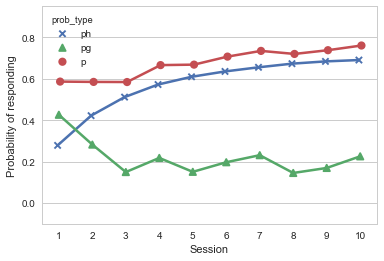

In [106]:
data_schedule = pd.read_csv('RR_10_07-02-2019_13-20.csv')
sns.set(style='whitegrid', font_scale=1)
g = sns.pointplot(x='session', y='prob_value',
          data=data_schedule, dodge=True,
          hue='prob_type', linestyles=['-', '-', '-'], ci=None, markers=['x','^','o'], scale=0.8)
axis=g.axes
axis.set(ylim=(-.1, .95), ylabel='Probability of responding', xlabel='Session')
#plt.savefig('RR_y10_gd_chapter.png', dpi=800)

Now we set everything again for the following cycles, which are one window long.

In [33]:
respPerWin = respPerWin[1:len(respPerWin)]
respPerWinLastCycleToAppend = respPerWin[1:len(respPerWin)]

schedule = Schedule('RI', 10, m=10)
exp = Exp(nLevers=1, nCycles=1)
cycle = Cycle(prob=0.6, winNumber=1, winLength=10)

respPerMin = cycle.prob*60 # number of resp/min, just to print it
#print('resp per min: %g') %respPerMin

# T = np.zeros(exp.nCycles)
# T = cycle.winLength*cycle.winNumber
nCycles = 1
resp, reinf, IRT = np.zeros(T), np.zeros(T), np.zeros(T)
rnfFlag = False

for t in xrange(T):
    if schedule.name in ['RI']:
        if not rnfFlag: # this flags the reinf for RI
            rnfFlag = np.random.binomial(1, 1/schedule.parameter)                
    resp[t] = np.random.binomial(1, cycle.prob)
    if resp[t]:
        schedule.giveRnf()    

calculate_corr()
calculate_h()


resp per min: 36
g = nan
h = 0


0.0

[0.5, 0.88079707797788231, 0.98201379003790845, 0.99752737684336534, 0.99966464986953363, 0.99995460213129761, 0.99999385582539779, 0.99999916847197223, 0.99999988746483792, 0.9999999847700205]


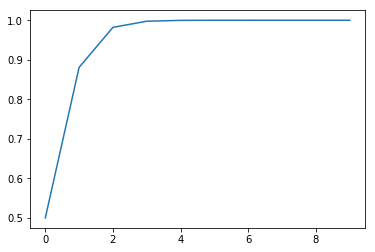

In [23]:
def sigmoid(x):
    return 1/(1+exp(-2*x))

y = []
x = range(10)
for k in x:
    y.append(sigmoid(k))
print y

plt.plot(x,y)

In [24]:
pip install jupyter_contrib_nbextensions

SyntaxError: invalid syntax (<ipython-input-24-123be2900413>, line 1)

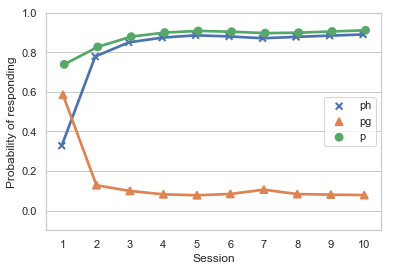

In [10]:
dataRI = pd.read_csv('RI_10.csv')
dataRI.tail()
#print(pg[cycle_number-1], ph[cycle_number-1], p[cycle_number-1])%%!

# plot lines for each system
sns.set(style='whitegrid', font_scale=1)
g = sns.pointplot(x='session', y='prob_value',
          data=dataRI, dodge=True,
          hue='prob_type', linestyles=['-', '-', '-'], ci=None, markers=['x','^','o'], scale=1)
axis = g.axes
axis.set(ylim=(-.1, 1), ylabel='Probability of responding', xlabel='Session')
plt.legend(loc='right')
#plt.savefig('RR_y10_gd_chapter.png', dpi=800)

# Choice (Kosaki and Dickinson's 2010 exp.)